**Les Membres du groupe :**
- KOUCH HAJAR
- LAARAJ IMANE
- ZMIRLI MUSTAPHA

# Analyse des donn√©es d'√©conomie, emploi et √©ducation avec l'API OCDE
**Introduction :**
Les in√©galit√©s en mati√®re de d√©veloppement humain et d'emploi constituent des enjeux majeurs dans le monde contemporain. Ces disparit√©s sont influenc√©es par une combinaison complexe de facteurs √©conomiques, √©ducatifs, sociaux et d√©mographiques. **L'objectif de cette √©tude est de comprendre comment ces indicateurs interagissent et contribuent aux diff√©rences de d√©veloppement entre les pays et les r√©gions.**

Dans ce notebook, nous analysons des donn√©es issues des pays membres de l'OCDE ainsi que World Bank, collect√©es pour l'ann√©e 2021 √† partir de l'API de l'OCDE et l'api World Bank. Cette analyse int√©gr√©e porte sur des domaines cl√©s, notamment les niveaux d'√©ducation, les politiques fiscales, les investissements publics et les variables macro√©conomiques. Elle vise √† r√©pondre aux questions suivantes :

*  Comment les niveaux d'√©ducation et les domaines d'√©tudes influencent-ils les taux d'emploi et de ch√¥mage au sein de diff√©rents groupes d√©mographiques ?

* Quels sont les effets des politiques fiscales et des investissements publics sur les indicateurs socio-√©conomiques ?

* En quoi les variables macro√©conomiques et sociales, comme le PIB ou les d√©penses publiques en sant√© et √©ducation, expliquent-elles les disparit√©s de d√©veloppement humain entre pays et r√©gions ?

**Importation des bibliotheques :**

In [ ]:
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_white
from scipy.stats import shapiro
from sklearn.linear_model import LinearRegression
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from adjustText import adjust_text

# 1. Chargement des donn√©es de l'api OCDE :


**Pour acc√©der aux donn√©es depuis l'API OCDE, nous utiliserons la biblioth√®que pandas et des requ√™tes HTTP via requests.**

In [ ]:
# URLs des ensembles de donn√©es
ocde_DATA_url='https://sdmx.oecd.org/public/rest/data/OECD.SDD.TPS,DSD_PPP@DF_PPP,1.0/DEU+AUS+AUT+BEL+CAN+CHL+COL+KOR+CRI+DNK+ESP+EST+USA+FIN+FRA+GRC+HUN+IRL+ISL+ITA+JPN+LVA+LTU+LUX+MEX+NOR+NZL+NLD+POL+PRT+SVK+GBR+SVN+SWE+CHE+CZE+TUR.A.PPP.A01+A0101+A010101+A01010101+A01010102+A01010103+A01010104+A01010105+A01010106+A01010199+A010102+A0102+A010201+A010202+A0103+A0104+A0105+A0106+A010601+A0107+A010701+A0108+A0109+A0110+A0111+A0112.XDC_USD.OECD?startPeriod=2021&endPeriod=2021&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
taux_chomage_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP_FIELD,1.0/SWE+IRL+LUX+AUS+AUT+BEL+CHL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+ITA+LVA+LTU+MEX+NLD+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA.F+M.Y55T64+Y45T54+Y35T44+Y25T34.ISCED11A_7_8+ISCED11A_6+ISCED11A_5+ISCED11A_5T8.F00_08_10+F05T07+F022T03+F02_03+F01+F02+F03+F04+F05+F06+F07+F08+F09+F10.........OBS...A3?startPeriod=2021&endPeriod=2021&dimensionAtObservation=AllDimensions&format=csvfilewithlabels'
taux_emploi_url='https://sdmx.oecd.org/public/rest/data/OECD.EDU.IMEP,DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_FIELD,1.0/SWE+IRL+LUX+AUS+AUT+BEL+CHL+CRI+CZE+DNK+EST+FIN+FRA+DEU+GRC+HUN+ISL+ITA+LVA+LTU+MEX+NLD+NOR+POL+PRT+SVK+SVN+ESP+CHE+TUR+GBR+USA.F+M.Y25T64.ISCED11A_7_8+ISCED11A_5+ISCED11A_6.F01+F02+F03+F04+F05+F06+F07+F08+F09+F10.........OBS...A3?startPeriod=2021&endPeriod=2021&lastNObservations=1&dimensionAtObservation=AllDimensions'
# Liste des URLs avec leurs noms de fichier correspondants
urls = [
    {"url": ocde_DATA_url, "filename": "ocde_DATA.csv"},
    {"url": taux_chomage_url, "filename": "Taux_Chomage.csv"},
    {"url": taux_emploi_url, "filename": "taux_emploi.csv"}
]

# En-t√™tes de la requ√™te
headers = {
    'Accept': 'application/vnd.sdmx.data+csv; charset=utf-8'
}

# Fonction pour t√©l√©charger et sauvegarder les donn√©es
def download_data(url, filename):
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Le fichier '{filename}' a √©t√© t√©l√©charg√© avec succ√®s.")
    else:
        print(f"Erreur {response.status_code} lors du t√©l√©chargement de {filename}")

# Boucle pour t√©l√©charger chaque jeu de donn√©es
for item in urls:
    download_data(item["url"], item["filename"])


Le fichier 'ocde_DATA.csv' a √©t√© t√©l√©charg√© avec succ√®s.
Le fichier 'Taux_Chomage.csv' a √©t√© t√©l√©charg√© avec succ√®s.
Le fichier 'taux_emploi.csv' a √©t√© t√©l√©charg√© avec succ√®s.


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Taux d'emploi dataset :


Ce dataset fournit des informations sur le taux d'emploi selon :
          

*   le niveau d'√©tude  .
*   le domaine d'√©tude.
*   les groupes d'age et le genre selon diff√©rents pays

In [ ]:
# Charger le fichier CSV
tauxEmploi = pd.read_csv("/content/drive/MyDrive/tauxEmp2021.csv")
tauxEmploi.head()

STRUCTURE                                       STRUCTURE_ID  \
0  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...   
1  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...   
2  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...   
3  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...   
4  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_EMP_F...   

                                      STRUCTURE_NAME ACTION REF_AREA  \
0  Taux d'emploi des adultes dipl√¥m√©s de l'enseig...      I      GBR   
1  Taux d'emploi des adultes dipl√¥m√©s de l'enseig...      I      AUT   
2  Taux d'emploi des adultes dipl√¥m√©s de l'enseig...      I      NLD   
3  Taux d'emploi des adultes dipl√¥m√©s de l'enseig...      I      NLD   
4  Taux d'emploi des adultes dipl√¥m√©s de l'enseig...      I      EST   

  Zone de r√©f√©rence SEX           Sexe     AGE             √Çge  ...  \
0       Royaume-Uni   M  Sexe masculin  Y25T34  De 25 √† 34 ans  ...   
1          Autriche   F   Sexe f√©minin  Y55T64  De 55 √† 64 ans  ...   
2          Pays-Bas   F   Sexe f√©minin  Y35T44  De 35 √† 44 ans  ...   
3          Pays-Bas   F   Sexe f√©minin  Y45T54  De 45 √† 54 ans  ...   
4           Estonie   M  Sexe masculin  Y55T64  De 55 √† 64 ans  ...   

   OBS_VALUE Valeur d'observation OBS_STATUS Statut d'observation CONF_STATUS  \
0        NaN                  NaN          O                  NaN         NaN   
1        NaN                  NaN          O                  NaN         NaN   
2        NaN                  NaN          O                  NaN         NaN   
3  81.568626                  NaN          A                  NaN         NaN   
4        NaN                  NaN          O                  NaN         NaN   

  Statut de confidentialit√© UNIT_MULT Multiplicateur d'unit√©s DECIMALS  \
0                       NaN         0                     NaN        1   
1                       NaN         0                     NaN        1   
2                       NaN         0                     NaN        1   
3                       NaN         0                     NaN        1   
4                       NaN         0                     NaN        1   

  D√©cimales  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

[5 rows x 50 columns]

**Suppression des colonnes inutiles**

In [ ]:
# Supprimer les colonnes inutiles
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'REF_AREA',
     'Sexe', 'AGE','ATTAINMENT_LEV',
     'EDUCATION_FIELD', 'MEASURE',
    'Mesure', 'INCOME', 'Revenu', 'BIRTH_PLACE', 'Lieu de naissance',
    'MIGRATION_AGE', '√Çge au moment de la migration', 'EDU_STATUS',
    'Situation de scolarisation', 'LABOUR_FORCE_STATUS',
    'Situation d\'activit√©', 'DURATION_UNEMP', 'Dur√©e du ch√¥mage',
    'UNIT_MEASURE', 'Unit√© de mesure', 'STATISTICAL_OPERATION',
    'Op√©ration statistique', 'WORK_TIME_ARNGMNT',
    'Am√©nagement du temps de travail', 'QUESTIONNAIRE',
    'Nom du questionnaire', 'FREQ', 'Fr√©quence d\'observation',
    'TIME_PERIOD', 'Unnamed: 39', 'Valeur d\'observation',
    'OBS_STATUS', 'Statut d\'observation', 'CONF_STATUS',
    'Statut de confidentialit√©', 'UNIT_MULT', 'Multiplicateur d\'unit√©s',
    'DECIMALS', 'D√©cimales'
]

# V√©rifier si les colonnes existent avant de les supprimer pour √©viter les erreurs
colonnes_existantes = [col for col in colonnes_a_supprimer if col in tauxEmploi.columns]
tauxEmploi = tauxEmploi.drop(columns=colonnes_existantes)



# Renommer les colonnes restantes si elles existent
colonnes_a_renommer = {
    'Zone de r√©f√©rence': 'Pays',
    'OBS_VALUE': 'taux emploi',
    '√Çge':'Age',
    'SEX':'Genre',
    'Niveau de scolarit√©': 'Niveau de scolarite',
    'Domaine d‚Äô√©tudes': 'Domaine etudes'
}

# V√©rifier si les colonnes √† renommer existent
colonnes_existantes_renommage = {k: v for k, v in colonnes_a_renommer.items() if k in tauxEmploi.columns}
tauxEmploi = tauxEmploi.rename(columns=colonnes_existantes_renommage)

# Afficher un aper√ßu des donn√©es
tauxEmploi.head()


Pays Genre             Age                    Niveau de scolarite  \
0  Royaume-Uni     M  De 25 √† 34 ans  Enseignement tertiaire de cycle court   
1     Autriche     F  De 55 √† 64 ans           Niveau licence ou √©quivalent   
2     Pays-Bas     F  De 35 √† 44 ans  Enseignement tertiaire de cycle court   
3     Pays-Bas     F  De 45 √† 54 ans           Niveau licence ou √©quivalent   
4      Estonie     M  De 55 √† 64 ans  Enseignement tertiaire de cycle court   

                                      Domaine etudes  taux emploi  
0                        Sant√© et protection sociale          NaN  
1                           Services (grand domaine)          NaN  
2  Technologies de l‚Äôinformation et de la communi...          NaN  
3  Sciences, technologie, ing√©nierie et math√©mati...    81.568626  
4      Sciences sociales, journalisme et information          NaN

**Suppression des doublons et remplacer des valeurs manquantes par les moyennes**

In [ ]:
# V√©rifier les colonnes num√©riques
numerical_columns = tauxEmploi .select_dtypes(include=['number']).columns

# Remplacer les valeurs nulles uniquement dans les colonnes num√©riques par la moyenne
tauxEmploi[numerical_columns] = tauxEmploi [numerical_columns].fillna(tauxEmploi [numerical_columns].mean())

# Supprimer les doublons
tauxEmploi  = tauxEmploi .drop_duplicates()

tauxEmploi.head()


Pays Genre             Age                    Niveau de scolarite  \
0  Royaume-Uni     M  De 25 √† 34 ans  Enseignement tertiaire de cycle court   
1     Autriche     F  De 55 √† 64 ans           Niveau licence ou √©quivalent   
2     Pays-Bas     F  De 35 √† 44 ans  Enseignement tertiaire de cycle court   
3     Pays-Bas     F  De 45 √† 54 ans           Niveau licence ou √©quivalent   
4      Estonie     M  De 55 √† 64 ans  Enseignement tertiaire de cycle court   

                                      Domaine etudes  taux emploi  
0                        Sant√© et protection sociale    85.427044  
1                           Services (grand domaine)    85.427044  
2  Technologies de l‚Äôinformation et de la communi...    85.427044  
3  Sciences, technologie, ing√©nierie et math√©mati...    81.568626  
4      Sciences sociales, journalisme et information    85.427044

In [ ]:
# Sauvegarder les donn√©es nettoy√©es dans un fichier CSV
tauxEmploi.to_csv('tauxEmploiClean.csv', index=False)

# 3. Taux de chomage dataset

**Le jeu de donn√©es "Taux de ch√¥mage des adultes dipl√¥m√©s de l'enseignement sup√©rieur" fournit des informations sur le taux de ch√¥mage des adultes ayant obtenu un dipl√¥me de l'enseignement sup√©rieur. Les donn√©es sont ventil√©es par domaine d'√©tudes, niveau d'√©tudes, groupe d'√¢ge et sexe.**

**Importation des biblioth√®ques et chargement des donn√©es**

In [ ]:
# Charger le fichier CSV
file_path = 'Taux_Chomage.csv'  # Remplacez par le chemin r√©el du fichier
data = pd.read_csv(file_path)

# Afficher les premi√®res lignes et les informations g√©n√©rales
print("Aper√ßu des premi√®res lignes :")
display(data.head())
print("\nInformations g√©n√©rales :")
data.info()


Aper√ßu des premi√®res lignes :


STRUCTURE                                       STRUCTURE_ID  \
0  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...   
1  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...   
2  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...   
3  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...   
4  DATAFLOW  OECD.EDU.IMEP:DSD_EAG_LSO_EA@DF_LSO_NEAC_UNEMP...   

                                      STRUCTURE_NAME ACTION REF_AREA  \
0  Taux de ch√¥mage des adultes dipl√¥m√©s de l'ense...      I      CHE   
1  Taux de ch√¥mage des adultes dipl√¥m√©s de l'ense...      I      FRA   
2  Taux de ch√¥mage des adultes dipl√¥m√©s de l'ense...      I      LTU   
3  Taux de ch√¥mage des adultes dipl√¥m√©s de l'ense...      I      POL   
4  Taux de ch√¥mage des adultes dipl√¥m√©s de l'ense...      I      BEL   

  Zone de r√©f√©rence SEX           Sexe     AGE             √Çge  ... OBS_VALUE  \
0            Suisse   F   Sexe f√©minin  Y45T54  De 45 √† 54 ans  ...       NaN   
1            France   F   Sexe f√©minin  Y55T64  De 55 √† 64 ans  ...       NaN   
2          Lituanie   F   Sexe f√©minin  Y45T54  De 45 √† 54 ans  ...       NaN   
3           Pologne   M  Sexe masculin  Y35T44  De 35 √† 44 ans  ...       NaN   
4          Belgique   M  Sexe masculin  Y25T34  De 25 √† 34 ans  ...       NaN   

  Valeur d'observation OBS_STATUS Statut d'observation CONF_STATUS  \
0                  NaN          A         Normal value           C   
1                  NaN          O        Missing value         NaN   
2                  NaN          O        Missing value         NaN   
3                  NaN          O        Missing value         NaN   
4                  NaN          O        Missing value         NaN   

                Statut de confidentialit√© UNIT_MULT Multiplicateur d'unit√©s  \
0  Information statistique confidentielle         0                   Units   
1                                     NaN         0                   Units   
2                                     NaN         0                   Units   
3                                     NaN         0                   Units   
4                                     NaN         0                   Units   

  DECIMALS D√©cimales  
0        1       One  
1        1       One  
2        1       One  
3        1       One  
4        1       One  

[5 rows x 50 columns]


Informations g√©n√©rales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12544 entries, 0 to 12543
Data columns (total 50 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   STRUCTURE                        12544 non-null  object 
 1   STRUCTURE_ID                     12544 non-null  object 
 2   STRUCTURE_NAME                   12544 non-null  object 
 3   ACTION                           12544 non-null  object 
 4   REF_AREA                         12544 non-null  object 
 5   Zone de r√©f√©rence                12544 non-null  object 
 6   SEX                              12544 non-null  object 
 7   Sexe                             12544 non-null  object 
 8   AGE                              12544 non-null  object 
 9   √Çge                              12544 non-null  object 
 10  ATTAINMENT_LEV                   12544 non-null  object 
 11  Niveau de scolarit√©              12544 non-null 

**Suppression des colonnes unitiles**

In [ ]:
# Liste des colonnes utiles
colonnes_utiles = [
    'Zone de r√©f√©rence',
    'SEX',
    '√Çge',
    'Niveau de scolarit√©',
    'Domaine d‚Äô√©tudes',
    'OBS_VALUE',
]

# Filtrer les colonnes utiles
data_reduit = data[colonnes_utiles]
display(data_reduit.head())

Zone de r√©f√©rence SEX             √Çge  \
0            Suisse   F  De 45 √† 54 ans   
1            France   F  De 55 √† 64 ans   
2          Lituanie   F  De 45 √† 54 ans   
3           Pologne   M  De 35 √† 44 ans   
4          Belgique   M  De 25 √† 34 ans   

                     Niveau de scolarit√©  \
0           Niveau licence ou √©quivalent   
1           Niveau licence ou √©quivalent   
2           Niveau licence ou √©quivalent   
3           Niveau licence ou √©quivalent   
4  Enseignement tertiaire de cycle court   

                                    Domaine d‚Äô√©tudes  OBS_VALUE  
0  Sciences humaines (sauf langues), sciences soc...        NaN  
1  Ing√©nierie, industries de transformation et co...        NaN  
2  Sciences naturelles, math√©matiques et statisti...        NaN  
3                        Sant√© et protection sociale        NaN  
4                  Commerce, administration et droit        NaN

**Harmonisation des noms de colonnes**

In [ ]:
# Renommer les colonnes pour harmonisation
data_reduit = data_reduit.rename(columns={
    'Zone de r√©f√©rence': 'Pays',
    'SEX': 'Genre',
    '√Çge':'Age',
    'Niveau de scolarit√©': 'Niveau de scolarite',
    'Domaine d‚Äô√©tudes': 'Domaine etudes',
    'OBS_VALUE': 'Taux de Chomage'
})

print("Noms des colonnes harmonis√©s :")
display(data_reduit.head())

Noms des colonnes harmonis√©s :


Pays Genre             Age                    Niveau de scolarite  \
0    Suisse     F  De 45 √† 54 ans           Niveau licence ou √©quivalent   
1    France     F  De 55 √† 64 ans           Niveau licence ou √©quivalent   
2  Lituanie     F  De 45 √† 54 ans           Niveau licence ou √©quivalent   
3   Pologne     M  De 35 √† 44 ans           Niveau licence ou √©quivalent   
4  Belgique     M  De 25 √† 34 ans  Enseignement tertiaire de cycle court   

                                      Domaine etudes  Taux de Chomage  
0  Sciences humaines (sauf langues), sciences soc...              NaN  
1  Ing√©nierie, industries de transformation et co...              NaN  
2  Sciences naturelles, math√©matiques et statisti...              NaN  
3                        Sant√© et protection sociale              NaN  
4                  Commerce, administration et droit              NaN

Les Variables :                                                                                                          
Pays : Indique le pays auquel les donn√©es se rapportent.                                                               
Genre : Sp√©cifie le genre des individus repr√©sent√©s dans les donn√©es.                                                               
Age : Groupe d'√¢ge des individus dans l'√©tude.                                                               
Niveau de scolarite : Niveau d'√©tudes atteint par les individus.                                                               
Domaine etudes : Domaine d'√©tudes des individus dipl√¥m√©s.                                                                                   
Taux de Chomage : Pourcentage de la population active dans le m√™me sous-groupe qui est au ch√¥mage.

**Suppression des doublons**

In [ ]:
# Supprimer les doublons
data_reduit = data_reduit.drop_duplicates()

print("Doublons supprim√©s.")


Doublons supprim√©s.


**Suppression des valeurs Nulles**

In [ ]:
if 'Taux de Chomage' in data_reduit.columns:
    # Supprimer les lignes avec des valeurs manquantes dans la colonne 'Taux de Chomage'
    data_reduit = data_reduit.dropna(subset=['Taux de Chomage'])
    print("Les lignes avec des valeurs NaN dans la colonne 'Taux de Chomage' ont √©t√© supprim√©es.")
else:
    print("La colonne 'Taux de Chomage' n'existe pas dans le dataset.")


Les lignes avec des valeurs NaN dans la colonne 'Taux de Chomage' ont √©t√© supprim√©es.


##Exportation des donn√©es nettoy√©es

In [ ]:
output_path = 'Taux_Chomage_cleaned.csv'
data_reduit.to_csv(output_path, index=False)

print(f"Donn√©es nettoy√©es export√©es vers {output_path}")


Donn√©es nettoy√©es export√©es vers Taux_Chomage_cleaned.csv


# 4. Fusionner les datasets de Taux d'emploi avec Taux de chomage :

**Charger les deux dataset**

In [ ]:
tauxEmploi.to_csv('tauxEmploiClean.csv', index=False)
tauxChomage = pd.read_csv('/content/drive/MyDrive/Taux_Chomage_cleaned.csv')  # Dataset fusionn√© pr√©c√©dent
tauxChomage.head()

Pays Genre             Age                    Niveau de scolarite  \
0   Mexique     M  De 25 √† 34 ans                 Enseignement tertiaire   
1  Tch√©quie     M  De 45 √† 54 ans                 Enseignement tertiaire   
2   Espagne     M  De 45 √† 54 ans  Enseignement tertiaire de cycle court   
3  Pays-Bas     F  De 55 √† 64 ans  Niveau master, doctorat ou √©quivalent   
4   Mexique     F  De 45 √† 54 ans           Niveau licence ou √©quivalent   

                                      Domaine etudes  Taux de Chomage  
0                        Sant√© et protection sociale         4.056299  
1  Programmes et certifications g√©n√©riques; agric...         1.267853  
2  Ing√©nierie, industries de transformation et co...         5.097282  
3                  Commerce, administration et droit         1.990050  
4                          √âducation (grand domaine)         1.083778

**Faire la jointure sur les colonnes** : Pays,Age,Niveau de scolarite,Domaine etudes,Genre pour obtenir la data (tauxChomEmploi).

In [ ]:
tauxChomEmploi = pd.merge(
    tauxEmploi, tauxChomage,
    on=['Pays','Age','Niveau de scolarite','Domaine etudes','Genre'],
    how='inner'
)

# Afficher les premi√®res lignes du dataset final
tauxChomEmploi.head()
tauxChomEmploi = tauxChomEmploi[tauxChomEmploi['Niveau de scolarite'] != 'Enseignement tertiaire']
# Sauvegarder dans un nouveau fichier CSV
tauxChomEmploi.to_csv('tauxChomEmploi.csv', index=False)
tauxChomEmploi.head()


Pays Genre             Age                    Niveau de scolarite  \
0   Pays-Bas     F  De 45 √† 54 ans           Niveau licence ou √©quivalent   
2   Slov√©nie     M  De 35 √† 44 ans  Niveau master, doctorat ou √©quivalent   
3     Suisse     F  De 35 √† 44 ans           Niveau licence ou √©quivalent   
5  Allemagne     M  De 45 √† 54 ans  Niveau master, doctorat ou √©quivalent   
6     Suisse     M  De 25 √† 34 ans  Niveau master, doctorat ou √©quivalent   

                                      Domaine etudes  taux emploi  \
0  Sciences, technologie, ing√©nierie et math√©mati...    81.568626   
2                          √âducation (grand domaine)    91.121391   
3                                    Lettres et arts    72.585220   
5  Sciences humaines (sauf langues), sciences soc...    92.181023   
6  Ing√©nierie, industries de transformation et co...    95.193298   

   Taux de Chomage  
0         2.347418  
2         7.145464  
3        15.116038  
5         3.538925  
6         3.940461

**Analyse exploratoire de tauxChomEmploi :**

**Visualisation de distribution de taux d'emploi selon le niveau d'√©tude**

<ipython-input-8-51f87ee2558e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emploi_par_niveau,


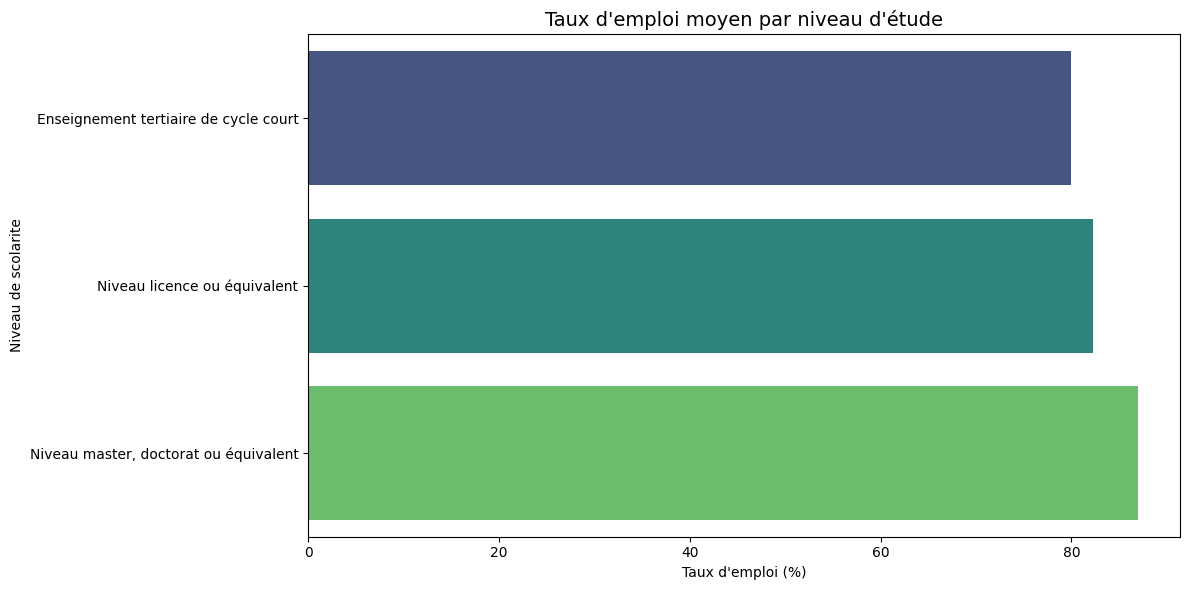

In [ ]:

emploi_par_niveau = (
    tauxChomEmploi.groupby('Niveau de scolarite')['taux emploi']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les donn√©es avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=emploi_par_niveau,
            x='taux emploi',
            y='Niveau de scolarite',
            palette='viridis')

plt.title("Taux d'emploi moyen par niveau d'√©tude", fontsize=14)
plt.xlabel("Taux d'emploi (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()




*   Le taux d'emploi moyen augmente avec le niveau d'√©tudes.
*   Les personnes ayant un niveau d'√©tudes plus √©lev√© (Master, Doctorat ou √©quivalent) ont le taux d'emploi le plus √©lev√©.


*  
Les personnes avec un niveau licence ont un taux d'emploi l√©g√®rement inf√©rieur √† celui des niveaux Master/Doctorat, mais sup√©rieur √† celui des √©tudes tertiaires de cycle court.
*   √âl√©ment de liste

Ce graphique montre une corr√©lation positive entre le niveau d'√©tudes et le taux d'emploi moyen. Les individus ayant des qualifications plus √©lev√©es (Master, Doctorat) semblent avoir de meilleures opportunit√©s d'emploi,




**Visualisation de distribution de taux d'emploi selon le domaine d'√©tude**

<ipython-input-9-21094f876e91>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=emploi_par_domaine,


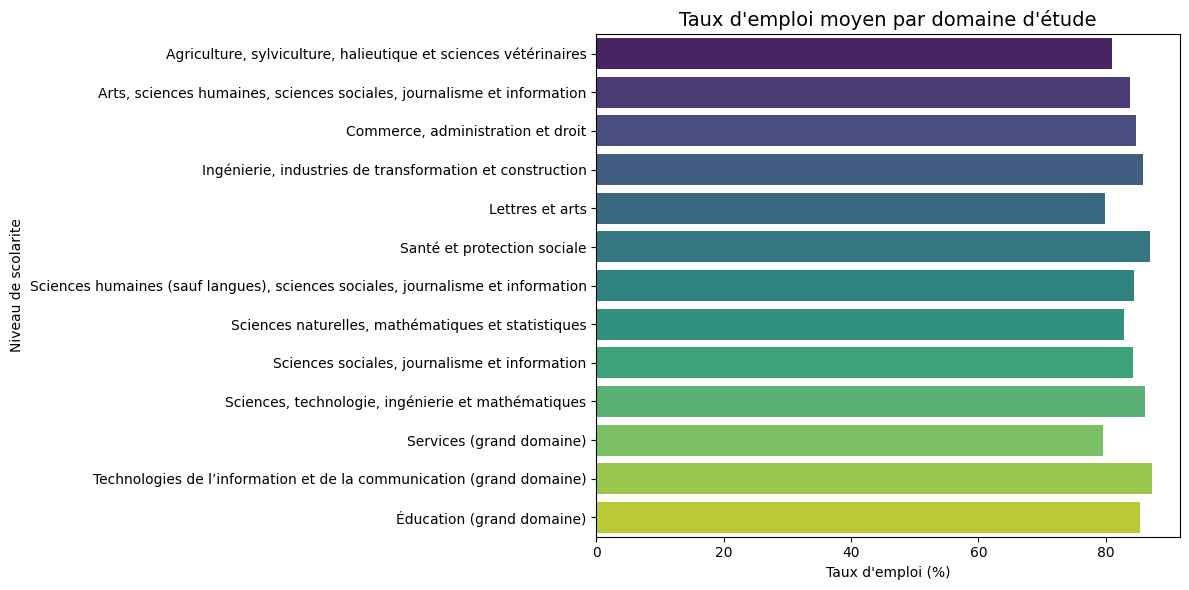

In [ ]:

emploi_par_domaine = (
    tauxChomEmploi.groupby('Domaine etudes')['taux emploi']
    .mean()
    .sort_index()
    .reset_index()
)

# Visualiser les donn√©es avec un diagramme en barres
plt.figure(figsize=(12, 6))
sns.barplot(data=emploi_par_domaine,
            x='taux emploi',
            y='Domaine etudes',
            palette='viridis')

plt.title("Taux d'emploi moyen par domaine d'√©tude", fontsize=14)
plt.xlabel("Taux d'emploi (%)")
plt.ylabel("Niveau de scolarite")
plt.tight_layout()
plt.show()



1.   Domaines avec les taux d'emploi les plus √©lev√©s :


*   Technologies de l‚Äôinformation et de la communication (grand domaine) suit de pr√®s, ce qui refl√®te la forte demande dans ce secteur.
*   √âducation (grand domaine) a le taux d'emploi le plus √©lev√© parmi les domaines repr√©sent√©s.



2.   Domaines avec des taux d'emploi mod√©r√©s :


*   
Les domaines comme services, sciences, technologie, ing√©nierie et math√©matiques affichent des taux d'emploi comp√©titifs.
3.  
Domaines avec les taux d'emploi les plus faibles :


*   Les secteurs tels que agriculture, sylviculture, halieutique et sciences v√©t√©rinaires et arts, sciences humaines, sciences sociales, journalisme et information ont des taux d'emploi inf√©rieurs compar√©s aux autres.








**Analyse de donn√©e de tauxEmploiChaumage :**

**Dans quelle mesure le taux de ch√¥mage impacte-t-il le taux d'emploi ?**

##On r√©pond en appliquant la r√©gression lin√©aire :

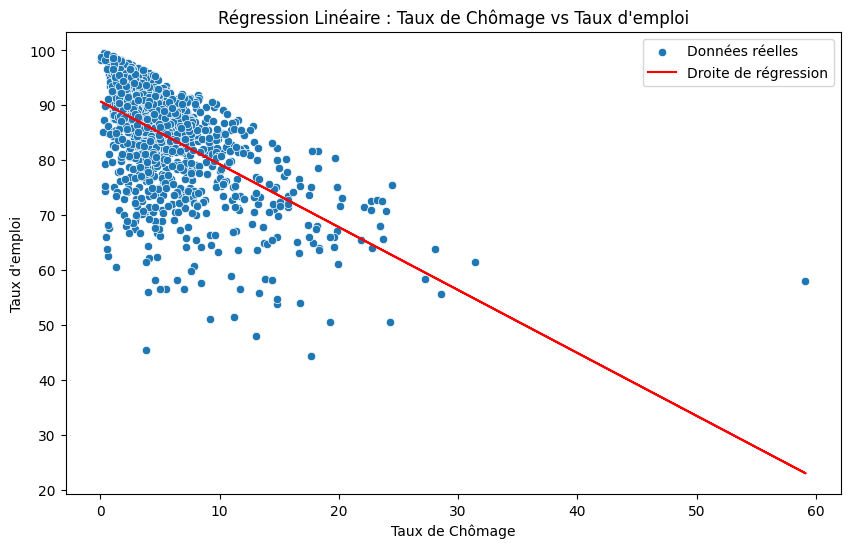

Coefficient de r√©gression (pente) : -1.1459794550043112
Ordonn√©e √† l'origine : 90.7302564292137
Score R^2 : 0.32586443443023394


In [ ]:

X = tauxChomEmploi[['Taux de Chomage']]  # Variable ind√©pendante
y = tauxChomEmploi['taux emploi']       # Variable d√©pendante

# Cr√©er une instance du mod√®le de r√©gression lin√©aire
reg_model = LinearRegression()

# Entra√Æner le mod√®le
reg_model.fit(X, y)

# Pr√©dire les valeurs de y bas√©es sur le mod√®le
y_pred = reg_model.predict(X)

# Tracer le nuage de points et la droite de r√©gression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['Taux de Chomage'], y=y, label='Donn√©es r√©elles')
plt.plot(X['Taux de Chomage'], y_pred, color='red', label='Droite de r√©gression')

# Ajouter des titres et des labels
plt.title('R√©gression Lin√©aire : Taux de Ch√¥mage vs Taux d\'emploi')
plt.xlabel('Taux de Ch√¥mage')
plt.ylabel('Taux d\'emploi')
plt.legend()

# Afficher le graphique
plt.show()

# Afficher les coefficients du mod√®le
print(f"Coefficient de r√©gression (pente) : {reg_model.coef_[0]}")
print(f"Ordonn√©e √† l'origine : {reg_model.intercept_}")
print(f"Score R^2 : {r2_score(y, y_pred)}")


* Corr√©lation n√©gative:

La pente de la droite est n√©gative, indiquant qu'il existe une relation inverse entre le taux de ch√¥mage et le taux d'emploi. En d'autres termes, plus le taux de ch√¥mage est √©lev√©, plus le taux d'emploi est faible.
Alignement des points :

* Les points sont globalement align√©s le long de la droite de r√©gression, ce qui sugg√®re que la r√©gression lin√©aire est un mod√®le raisonnable pour d√©crire cette relation. Cependant, il y a une certaine dispersion autour de la droite.

* Le
ùëÖ
  indique la proportion de la variance dans la variable d√©pendante (taux d'emploi) expliqu√©e par la variable ind√©pendante (taux de ch√¥mage).

* Un
ùëÖ
carr√©
  de 0.326 (ou 32.6 %) signifie que seulement environ 32.6 % de la variabilit√© du taux d'emploi est expliqu√©e par le taux de ch√¥mage.
Ce score est relativement faible, ce qui sugg√®re que d'autres facteurs non inclus dans le mod√®le influencent le taux d'emploi.



**Comment la dispersion des taux de ch√¥mage diff√®re-t-elle entre les diff√©rents niveaux d'√©tudes‚ÄØ?**

##On r√©pond en appliquant **ANOVA** :

**Voir  la normalit√© :**

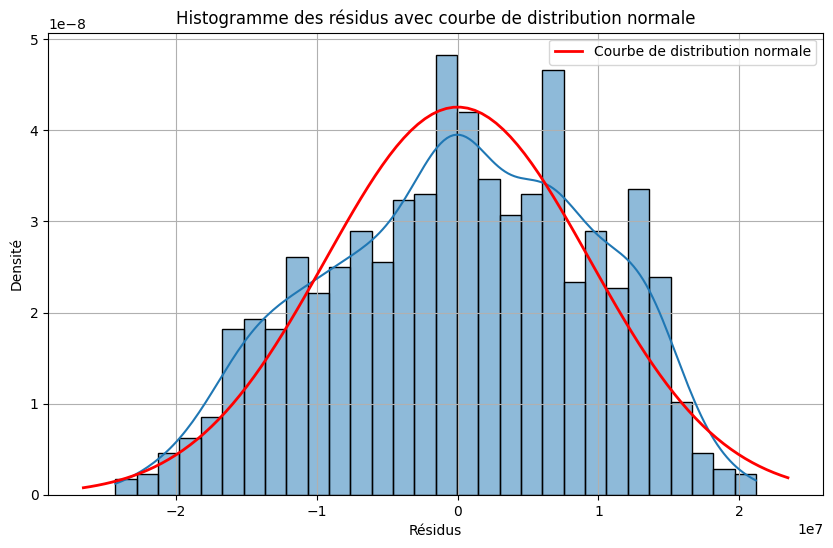

Shapiro-Wilk test apr√®s transformation logarithmique: W = 0.98452440987828 , p-value = 8.990888778297036e-10


In [ ]:
model = smf.ols('taux_emploi ~ C(Domaine_etudes)', data=df).fit()
residus = model.resid

# Cr√©er l'histogramme des r√©sidus
plt.figure(figsize=(10, 6))
sns.histplot(residus, kde=True, stat="density", bins=30)

# Ajouter une courbe de distribution normale
mu, std = stats.norm.fit(residus)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)  # PDF de la normale
plt.plot(x, p, 'r', linewidth=2, label='Courbe de distribution normale')

# Ajouter des titres et des labels
plt.title('Histogramme des r√©sidus avec courbe de distribution normale')
plt.xlabel('R√©sidus')
plt.ylabel('Densit√©')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()


Donc la distribution des r√©sidus est normale, ce qui est un bon signe pour la validit√© du mod√®le.

**Visualiser les diff√©rences  entre les niveaux √©tudes en fonction de taux de chomage et √©valuer la dispersion des donn√©es**

<ipython-input-11-14bea7e1eb05>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Niveau_de_scolarite', y='Taux_de_Chomage', palette='coolwarm')


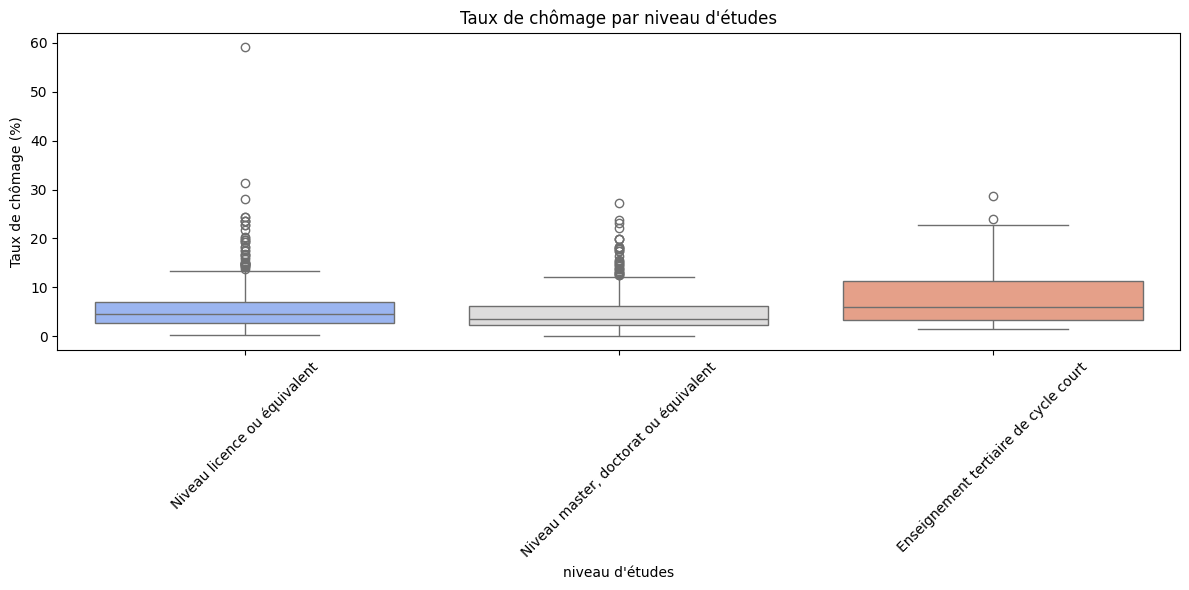

In [ ]:
df = tauxChomEmploi.rename(columns={
    'Taux de Chomage': 'Taux_de_Chomage',
    'Niveau de scolarite': 'Niveau_de_scolarite'
})

# ANOVA apr√®s renommage des colonnes
model = ols('Taux_de_Chomage ~ C(Niveau_de_scolarite)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Visualisation des donn√©es
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Niveau_de_scolarite', y='Taux_de_Chomage', palette='coolwarm')
plt.title("Taux de ch√¥mage par niveau d'√©tudes")
plt.xlabel("niveau d'√©tudes")
plt.ylabel("Taux de ch√¥mage (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



**Niveau master, doctorat ou √©quivalent :**

Bo√Æte basse, m√©diane proche de Q1, moustaches courtes avec plusieurs valeurs aberrantes (ces valeurs aberrantes repr√©sentent des individus ou des sous-groupes dont le taux de ch√¥mage est exceptionnellement √©lev√© par rapport √† la majorit√© des donn√©es. )

Interpr√©tation : Le taux de ch√¥mage est globalement faible, avec peu de variabilit√©. La plupart des individus de ce groupe ont un taux de ch√¥mage similaire.

**Niveau licence ou √©quivalent :**

Bo√Æte plus haute, m√©diane au centre, moustaches mod√©r√©es.

Interpr√©tation : Le taux de ch√¥mage est plus √©lev√© que pour le groupe pr√©c√©dent, avec une variabilit√© mod√©r√©e. La distribution est sym√©trique. Certains individus de ce groupe ont des taux de ch√¥mage exceptionnellement √©lev√©s .

**Enseignement tertiaire de cycle court :**

Bo√Æte tr√®s haute, m√©diane proche de Q3, moustaches longues avec plusieurs valeurs aberrantes.

Interpr√©tation : Le taux de ch√¥mage est globalement √©lev√©, avec une grande despertion.

##Lancer Anova :

In [ ]:
import statsmodels.formula.api as smf
anova_variete = smf.ols('Taux_de_Chomage~Niveau_de_scolarite', data=df).fit()
print(anova_variete.summary())

                            OLS Regression Results                            
Dep. Variable:        Taux_de_Chomage   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     18.34
Date:                Fri, 03 Jan 2025   Prob (F-statistic):           1.44e-08
Time:                        14:01:40   Log-Likelihood:                -3446.9
No. Observations:                1161   AIC:                             6900.
Df Residuals:                    1158   BIC:                             6915.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

**Interpretation :**

* Par le test de Fisher PR(>F) : La valeur p est de 1.44e-08, cette valeur extr√™mement faible (< 0.05) indique qu'il y a une diff√©rence significative entre les niveaux d'√©tudes.
* Conclusion :
Les niveaux d'√©tudes influencent significativement le taux de chomage .


##Post-hoc test pour identifier les diff√©rences sp√©cifiques :


In [ ]:
# Test Tukey HSD (test post hoc)
tukey_results = pairwise_tukeyhsd(
    df['Taux_de_Chomage'],  # La variable d√©pendante
    df['Niveau_de_scolarite']  # La variable de groupe
)

print("\nTukey HSD Results:")
print(tukey_results)



Tukey HSD Results:
                               Multiple Comparison of Means - Tukey HSD, FWER=0.05                                
                group1                                group2                meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------------
Enseignement tertiaire de cycle court          Niveau licence ou √©quivalent  -2.1723 0.0002 -3.4544 -0.8902   True
Enseignement tertiaire de cycle court Niveau master, doctorat ou √©quivalent  -3.1279    0.0 -4.4047 -1.8511   True
         Niveau licence ou √©quivalent Niveau master, doctorat ou √©quivalent  -0.9556 0.0027 -1.6315 -0.2797   True
------------------------------------------------------------------------------------------------------------------


**Interpretation :**

1.   Enseignement tertiaire de cycle court vs Niveau licence ou √©quivalent :

Il y a une diff√©rence significative entre ces deux groupes. Le taux de ch√¥mage est plus √©lev√© de 2.17 points dans le groupe "Enseignement tertiaire de cycle court" par rapport au groupe "Niveau licence ou √©quivalent".
2.   Enseignement tertiaire de cycle court vs Niveau master, doctorat ou √©quivalent :

Il y a une diff√©rence significative entre ces deux groupes. Le taux de ch√¥mage est plus √©lev√© de 3.13 points dans le groupe "Enseignement tertiaire de cycle court" par rapport au groupe "Niveau master, doctorat ou √©quivalent".

3. Niveau licence ou √©quivalent vs Niveau master, doctorat ou √©quivalent :

Le taux de ch√¥mage est plus √©lev√© de 0.96 point dans le groupe "Niveau licence ou √©quivalent" par rapport au groupe "Niveau master, doctorat ou √©quivalent".


Conclusion g√©n√©rale :

Le groupe "Enseignement tertiaire de cycle court" a un taux de ch√¥mage significativement plus √©lev√© que les deux autres groupes ("Niveau licence ou √©quivalent" et "Niveau master, doctorat ou √©quivalent").

Le groupe "Niveau licence ou √©quivalent" a un taux de ch√¥mage significativement plus √©lev√© que le groupe "Niveau master, doctorat ou √©quivalent".

##**Y a-t-il une forte variabilit√© du taux d'emploi selon les domaines d'√©tudes ?**

##Visualiser les diff√©rences  entre les domaines d'√©tudes en fonction de taux d'emploi et √©valuer la dispersion des donn√©es


Domaines montrant une diff√©rence significative:


<ipython-input-26-2bb6de818e43>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_significant, x='Domaine_etudes', y='taux_emploi', palette='coolwarm')


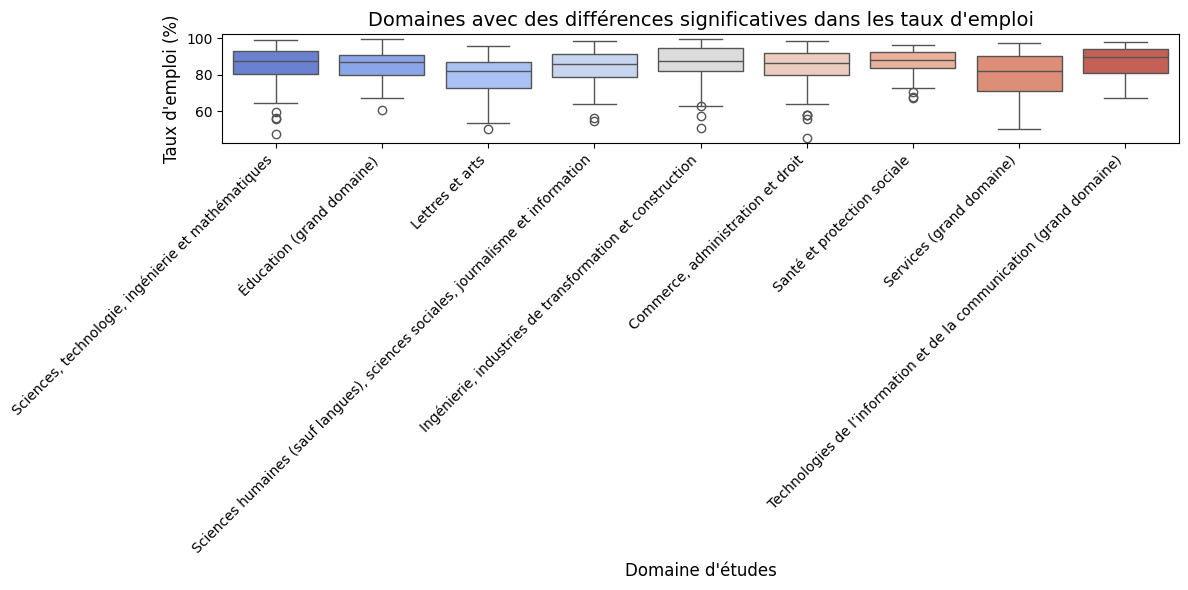

In [ ]:
df = tauxChomEmploi.rename(columns={
    'taux emploi': 'taux_emploi',
    'Domaine etudes': 'Domaine_etudes'
})

# Visualisation initiale des donn√©es pour tous les domaines
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='Domaine_etudes', y='taux_emploi', palette='viridis')
plt.title("Taux d'emploi par domaine d'√©tudes (tous les domaines)", fontsize=16)
plt.xlabel("Domaine d'√©tudes", fontsize=12)
plt.ylabel("Taux d'emploi (%)", fontsize=12)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.tight_layout()
plt.show()


Voici une analyse d√©taill√©e pour chacun des 6 domaines pr√©sent√©s dans le boxplot :

1. Sciences, technologie, ing√©nierie et math√©matiques (STIM)

* M√©diane : √âlev√©e, proche de 90 %, ce qui indique que la majorit√© des dipl√¥m√©s dans ce domaine trouvent un emploi.

* √âtendue interquartile (IQR) : Relativement faible, ce qui signifie que les taux d'emploi sont assez homog√®nes.

* Valeurs extr√™mes : Quelques outliers en dessous de 70 %, indiquant que certaines sp√©cialisations ou r√©gions peuvent poser des d√©fis.

2. √âducation (grand domaine)

* M√©diane : Relativement √©lev√©e, sup√©rieure √† 85 %.
* √âtendue interquartile (IQR) : Moyenne, montrant une certaine variabilit√© dans les taux d'emploi selon les sp√©cialit√©s ou niveaux (√©ducation primaire, secondaire, etc.).
* Valeurs extr√™mes : Plusieurs outliers sous 70 %, ce qui peut refl√©ter des disparit√©s r√©gionales dans l'offre d'emplois √©ducatifs.

3. Ing√©nierie, industries de transformation et construction
M√©diane : Tr√®s √©lev√©e, autour de 90 %.

* √âtendue interquartile (IQR) : Faible, indiquant une grande coh√©rence des opportunit√©s d'emploi dans ce domaine.
* Valeurs extr√™mes : Quelques valeurs sous 80 %, mais tr√®s peu.

4. Commerce, administration et droit
* M√©diane : Proche de 90 %, indiquant une bonne performance globale.
* √âtendue interquartile (IQR) : Moyenne, refl√©tant une certaine h√©t√©rog√©n√©it√© dans les r√©sultats en fonction des sous-domaines (par exemple, droit vs administration).
* Valeurs extr√™mes : Quelques outliers sous 70 %, ce qui peut correspondre √† des sp√©cialisations moins demand√©es.


5. Sant√© et protection sociale
* M√©diane : Sup√©rieure √† 85 %, indiquant une performance globale solide.
* √âtendue interquartile (IQR) : Assez large, montrant une plus grande dispersion dans les r√©sultats d'emploi.
* Valeurs extr√™mes : Plusieurs valeurs basses (inf√©rieures √† 70 %), ce qui pourrait √™tre d√ª √† des sp√©cialisations tr√®s sp√©cifiques ou √† un manque de postes disponibles dans certaines r√©gions.

6. Technologies de l'information et de la communication (grand domaine)
* M√©diane : Tr√®s √©lev√©e, proche de 90 %, confirmant un march√© de l'emploi solide.
* √âtendue interquartile (IQR) : Tr√®s faible, ce qui indique une grande stabilit√© dans les opportunit√©s d'emploi.
* Valeurs extr√™mes : Quelques rares outliers en dessous de 80 %, probablement des cas isol√©s.


7. Lettres et arts

* M√©diane : Inf√©rieure √† 85 %, indiquant une performance d‚Äôemploi plus faible par rapport √† d‚Äôautres domaines.
* √âtendue interquartile (IQR) : Moyenne √† large, montrant une variabilit√© importante des taux d‚Äôemploi selon les sp√©cialisations (arts plastiques, histoire de l‚Äôart, etc.).
* Valeurs extr√™mes : Plusieurs outliers en dessous de 70 %, sugg√©rant que certaines sp√©cialisations artistiques sont moins demand√©es sur le march√© de l‚Äôemploi.

8. Sciences humaines (sauf langues), sciences sociales, journalisme et information

* M√©diane : Aux alentours de 85 %, ce qui refl√®te un taux d‚Äôemploi acceptable, mais l√©g√®rement en dessous de certains autres domaines.
* √âtendue interquartile (IQR) : Moyenne, montrant une certaine h√©t√©rog√©n√©it√© dans les r√©sultats d‚Äôemploi selon les sous-domaines (sociologie, anthropologie, journalisme, etc.).
* Valeurs extr√™mes : Plusieurs valeurs inf√©rieures √† 70 %, particuli√®rement dans des sp√©cialisations moins populaires ou en demande.

9. Services (grand domaine)

* M√©diane : Moyenne, avoisinant les 80 %, ce qui en fait l‚Äôun des domaines avec les taux d‚Äôemploi les plus bas.
* √âtendue interquartile (IQR) : Large, illustrant une importante dispersion des r√©sultats selon les sp√©cialisations.
* Valeurs extr√™mes : Nombreuses valeurs en dessous de 70 %, mettant en √©vidence des d√©fis importants dans certaines branches (h√¥tellerie, restauration, etc.).

##Lan√ßons Anova :

In [ ]:
anova_variete = smf.ols('taux_emploi~Domaine_etudes', data=df).fit()
print(anova_variete.summary())

                            OLS Regression Results                            
Dep. Variable:            taux_emploi   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     4.445
Date:                Fri, 03 Jan 2025   Prob (F-statistic):           5.34e-07
Time:                        14:21:46   Log-Likelihood:                -4247.7
No. Observations:                1161   AIC:                             8521.
Df Residuals:                    1148   BIC:                             8587.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------



* Par le test de Fisher : On a p-value (PR(>F)) : 5.34√ó10‚àí75.34√ó10 ‚àí7
   Cette valeur extr√™mement faible (< 0.05) indique qu'il y a une diff√©rence significative entre les domaines d'√©tudes.

* Conclusion g√©n√©rale :
Donc les domaines d'√©tudes influencent significativement le taux d'emploi, en ligne avec les r√©sultats de l'ANOVA.
Les domaines techniques et li√©s aux TIC (technologies de l'information) offrent g√©n√©ralement de meilleures opportunit√©s, tandis que les fili√®res artistiques et sociales pr√©sentent des d√©fis plus importants pour l'int√©gration sur le march√© du travail.




##Post-hoc test pour identifier les diff√©rences sp√©cifiques :


In [ ]:
tukey_significant = pairwise_tukeyhsd(endog=df_significant['taux_emploi'],
                                      groups=df_significant['Domaine_etudes'],
                                      alpha=0.05)
print("\nTukey HSD Results :")
print(tukey_significant)


Tukey HSD Results :
                                                                          Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                                          
                                     group1                                                                          group2                                     meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                              Commerce, administration et droit                        Ing√©nierie, industries de transformation et construction    1.156 0.9859  -2.4407  4.7526  False
                                              Commerce, administration et droit                                                                 Lettres et arts  -4.9273 0.0029  -

**Commerce, administration et droit vs. Lettres et arts :**

Diff√©rence de moyenne (meandiff) : -4.9273

Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Lettres et arts a un taux d'emploi significativement plus √©lev√© que celui du Commerce, administration et droit.

**Commerce, administration et droit vs. Services (grand domaine) :**

Diff√©rence de moyenne (meandiff) : -5.2493

Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus √©lev√© que celui du Commerce, administration et droit.

**Ing√©nierie, industries de transformation et construction vs. Lettres et arts :**

Diff√©rence de moyenne (meandiff) : -6.0832


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Lettres et arts a un taux d'emploi significativement plus bas que celui de l'Ing√©nierie, industries de transformation et construction.

**Ing√©nierie, industries de transformation et construction vs. Services (grand domaine) :**

Diff√©rence de moyenne (meandiff) : -6.4053

Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus bas que celui de l'Ing√©nierie, industries de transformation et construction.

**Lettres et arts vs. Sant√© et protection sociale :**

Diff√©rence de moyenne (meandiff) : 7.1457


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine de la Sant√© et protection sociale a un taux d'emploi significativement plus √©lev√© que celui des Lettres et arts.

**Lettres et arts vs. Sciences humaines (sauf langues), sciences sociales, journalisme et information :**

Diff√©rence de moyenne (meandiff) : 4.5701

Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Sciences humaines a un taux d'emploi significativement plus √©lev√© que celui des Lettres et arts.

**Lettres et arts vs. Sciences, technologie, ing√©nierie et math√©matiques :**

Diff√©rence de moyenne (meandiff) : 6.2865


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des STIM a un taux d'emploi significativement plus √©lev√© que celui des Lettres et arts.

**Lettres et arts vs. Technologies de l‚Äôinformation et de la communication (grand domaine) :**

Diff√©rence de moyenne (meandiff) : 7.4712


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des TIC a un taux d'emploi significativement plus √©lev√© que celui des Lettres et arts.

**Lettres et arts vs. √âducation (grand domaine) :**

Diff√©rence de moyenne (meandiff) : 5.5558


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine de l'√âducation a un taux d'emploi significativement plus √©lev√© que celui des Lettres et arts.

**Sant√© et protection sociale vs. Services (grand domaine) :**

Diff√©rence de moyenne (meandiff) : -7.4677


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus bas que celui de la Sant√© et protection sociale.

**Sciences, technologie, ing√©nierie et math√©matiques vs. Services (grand domaine) :**

Diff√©rence de moyenne (meandiff) : -6.6085



Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des Services a un taux d'emploi significativement plus bas que celui des STIM.

**Services (grand domaine) vs. Technologies de l‚Äôinformation et de la communication (grand domaine) :**

Diff√©rence de moyenne (meandiff) : 7.7932


Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine des TIC a un taux d'emploi significativement plus √©lev√© que celui des Services.

**Services (grand domaine) vs. √âducation (grand domaine) :**

Diff√©rence de moyenne (meandiff) : 5.8779



Conclusion : La diff√©rence est statistiquement significative (reject = True). Le domaine de l'√âducation a un taux d'emploi significativement plus √©lev√© que celui des Services.

## 5. les donn√©es du dataset OCDE :

- Ce dataset contient des donn√©es socio-√©conomiques et d√©mographiques pour diff√©rents pays membres l'OCDE.
- Il fournit des indicateurs vari√©s pour comparer les performances √©conomiques, sociales et fiscales de ces pays.
- Chaque ligne repr√©sente un pays, et les colonnes contiennent des donn√©es sur des aspects comme les d√©penses publiques, la fiscalit√©...

In [ ]:
df = pd.read_csv('ocde_DATA.csv')
df.head()

STRUCTURE          STRUCTURE_ID     STRUCTURE_NAME ACTION LOCATION  \
0  DATAFLOW  OECD:DF_DP_LIVE(1.0)  OECD Data Archive      I      AUS   
1  DATAFLOW  OECD:DF_DP_LIVE(1.0)  OECD Data Archive      I      HUN   
2  DATAFLOW  OECD:DF_DP_LIVE(1.0)  OECD Data Archive      I      LUX   
3  DATAFLOW  OECD:DF_DP_LIVE(1.0)  OECD Data Archive      I      GRC   
4  DATAFLOW  OECD:DF_DP_LIVE(1.0)  OECD Data Archive      I      GRC   

         Pays   INDICATOR                              Indicateur SUBJECT  \
0   Australie         NNI                     Revenu national net     TOT   
1     Hongrie       GGEXP  D√©penses des administrations publiques     TOT   
2  Luxembourg  TAXPAYROLL                  Imp√¥t sur les salaires     TOT   
3       Gr√®ce  TAXPAYROLL                  Imp√¥t sur les salaires     TOT   
4       Gr√®ce  TAXPAYROLL                  Imp√¥t sur les salaires     TOT   

   Sujet  ...     OBS_VALUE Observation Value OBS_STATUS Observation Status  \
0  Total  ...  1.303851e+06               NaN          A                NaN   
1  Total  ...  4.835402e+01               NaN          A                NaN   
2  Total  ...  0.000000e+00               NaN          A                NaN   
3  Total  ...  0.000000e+00               NaN          A                NaN   
4  Total  ...  0.000000e+00               NaN          A                NaN   

   UNIT_MEASURE  Unit of Measures  UNIT_MULT  Multiplier BASE_PER  \
0           NaN               NaN        NaN         NaN      NaN   
1           NaN               NaN        NaN         NaN      NaN   
2           NaN               NaN        NaN         NaN      NaN   
3           NaN               NaN        NaN         NaN      NaN   
4           NaN               NaN        NaN         NaN      NaN   

   Base reference period  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 26 columns]

**Suppression des colonnes inutiles :**

In [ ]:
colonnes_a_supprimer = [
    'STRUCTURE', 'STRUCTURE_ID', 'STRUCTURE_NAME', 'ACTION', 'LOCATION',
    'SUBJECT', 'Sujet', 'FREQUENCY','UNIT_MEASURE','INDICATOR','MEASURE',
    'Fr√©quence', 'TIME_PERIOD','Temps','Observation Value','OBS_STATUS',
    'Observation Status', 'Unit of Measures', 'UNIT_MULT',
    'Stocks d\'IDE entrant par secteur d\‚Äôactivit√©',
    'Stocks d\'IDE sortant par secteur d\‚Äôactivit√©',
    'Multiplier', 'BASE_PER', 'Base reference period','Unit multiplier'
]

# Supprimer les colonnes inutiles
df_cleaned = df.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoy√©
df_cleaned.to_csv('ocde_DATA_nettoy√©.csv', index=False)
df_cleaned.head()


Pays                              Indicateur  \
0   Australie                     Revenu national net   
1     Hongrie  D√©penses des administrations publiques   
2  Luxembourg                  Imp√¥t sur les salaires   
3       Gr√®ce                  Imp√¥t sur les salaires   
4       Gr√®ce                  Imp√¥t sur les salaires   

                    Mesure        Valeur  
0   Millions de dollars US  1.303851e+06  
1                 % du PIB  4.835402e+01  
2                 % du PIB  0.000000e+00  
3  % des recettes fiscales  0.000000e+00  
4                 % du PIB  0.000000e+00

**Renommage des colonnes :**

In [ ]:
df_cleaned = df_cleaned.rename(columns={
    'OBS_VALUE': 'Valeur'
})

print(df_cleaned.head())

# Sauvegarder le dataset
df_cleaned.to_csv('ocde_DATA_nettoy√©_Renomm√©.csv', index=False)


         Pays                              Indicateur  \
0   Australie                     Revenu national net   
1     Hongrie  D√©penses des administrations publiques   
2  Luxembourg                  Imp√¥t sur les salaires   
3       Gr√®ce                  Imp√¥t sur les salaires   
4       Gr√®ce                  Imp√¥t sur les salaires   

                    Mesure        Valeur  
0   Millions de dollars US  1.303851e+06  
1                 % du PIB  4.835402e+01  
2                 % du PIB  0.000000e+00  
3  % des recettes fiscales  0.000000e+00  
4                 % du PIB  0.000000e+00  


**Pivotement des indicateurs en colonnes :**

In [ ]:
df = pd.read_csv('ocde_DATA_nettoy√©_Renomm√©.csv')

# Pivotement
df_pivot = df.pivot_table(index='Pays', columns='Indicateur', values='Valeur', aggfunc='first')
df_pivot.reset_index(inplace=True)

# Sauvegarder le r√©sultat
df_pivot.to_csv('DATA_OCDE_transformed.csv', index=False)


In [ ]:
df_pivot = pd.read_csv('DATA_OCDE_transformed.csv')
df_pivot.head()

Pays  D√©penses des administrations publiques  \
0  Allemagne                               51.030394   
1  Australie                               41.055219   
2   Autriche                            33627.870000   
3   Belgique                            32607.620000   
4     Canada                            24748.550000   

   Esp√©rance de vie √† la naissance  Heures travaill√©es  \
0                             80.8         1340.165629   
1                             83.3         1694.799343   
2                             81.3         1439.093920   
3                             81.9         1525.815277   
4                             81.6         1685.000000   

   Imp√¥t sur le revenu des personnes physiques  \
0                                       26.642   
1                                       39.003   
2                                        9.700   
3                                       26.686   
4                                       36.319   

   Imp√¥t sur les biens et services  Imp√¥t sur les b√©n√©fices des soci√©t√©s  \
0                           10.465                                 5.997   
1                            6.863                                 6.636   
2                           26.743                                 2.750   
3                           25.236                                 8.983   
4                            7.273                                13.482   

   Imp√¥t sur les salaires  Indices des niveaux de prix  \
0                   0.000                        100.0   
1                   1.274                        125.0   
2                   2.794                        103.0   
3                   0.002                        100.0   
4                   2.211                        114.0   

   Informatique √† domicile  ...  Produit int√©rieur brut (PIB)  \
0                      NaN  ...                  6.193981e+04   
1                      NaN  ...                  1.649096e+06   
2                      NaN  ...                  5.679881e+05   
3                      NaN  ...                  6.207716e+04   
4                      NaN  ...                  2.126696e+06   

   Recettes des administrations publiques  Recettes fiscales  \
0                            27944.470000           1682.006   
1                            22017.520000             29.482   
2                               50.391071             43.284   
3                            29381.090000            252.689   
4                               42.293369            679.059   

   Revenu national net  R√©mun√©ration horaire  Taux d'acc√®s Internet  \
0         5.227903e+04              0.591476                91.8750   
1         1.303851e+06                   NaN                    NaN   
2         1.055664e+02            119.639418                95.0006   
3         5.886212e+05              0.415288                92.2999   
4         1.150369e+02            117.694806                92.8000   

   Taux d'emploi  Taux de mortalit√© infantile  Taux de pauvret√©  \
0         75.600                          3.0               NaN   
1      13045.730                          3.3               NaN   
2         72.400                          2.7             0.098   
3         65.300                          2.9             0.078   
4         73.475                          NaN             0.105   

   Taux de suicide  
0              NaN  
1             12.4  
2             11.0  
3              NaN  
4              NaN  

[5 rows x 22 columns]

**Calcul du pourcentage des valeurs manquantes pour chaque colonne :**

In [ ]:
missing_percentage = df_pivot.isnull().mean() * 100

# Identifier les colonnes avec plus de 50 % de valeurs manquantes
columns_to_drop = missing_percentage[missing_percentage > 50].index

# Afficher les colonnes identifi√©es
print("Colonnes avec plus de 50 % de valeurs manquantes :", columns_to_drop.tolist())


Colonnes avec plus de 50 % de valeurs manquantes : ['Informatique √† domicile', 'Taux de suicide']


**Suppression des colonnes  avec plus de 50 % de valeurs manquantes :**

In [ ]:
df_cleaned = df_pivot.drop(columns=colonnes_a_supprimer, errors='ignore')


# Sauvegarder le dataset nettoy√©
df_cleaned.to_csv('DATA_OCDE_transformed3.csv', index=False)

In [ ]:
df = pd.read_csv('DATA_OCDE_transformed3.csv')
df.head()


Pays  D√©penses des administrations publiques  \
0  Allemagne                               51.030394   
1  Australie                               41.055219   
2   Autriche                            33627.870000   
3   Belgique                            32607.620000   
4     Canada                            24748.550000   

   Esp√©rance de vie √† la naissance  Heures travaill√©es  \
0                             80.8         1340.165629   
1                             83.3         1694.799343   
2                             81.3         1439.093920   
3                             81.9         1525.815277   
4                             81.6         1685.000000   

   Imp√¥t sur le revenu des personnes physiques  \
0                                       26.642   
1                                       39.003   
2                                        9.700   
3                                       26.686   
4                                       36.319   

   Imp√¥t sur les biens et services  Imp√¥t sur les b√©n√©fices des soci√©t√©s  \
0                           10.465                                 5.997   
1                            6.863                                 6.636   
2                           26.743                                 2.750   
3                           25.236                                 8.983   
4                            7.273                                13.482   

   Imp√¥t sur les salaires  Indices des niveaux de prix  Population active  \
0                   0.000                        100.0           42960.63   
1                   1.274                        125.0           13738.09   
2                   2.794                        103.0            4589.60   
3                   0.002                        100.0            5178.05   
4                   2.211                        114.0           20484.15   

   Population d'√¢ge actif  Produit int√©rieur brut (PIB)  \
0               64.065092                   5153144.247   
1               64.713578                   1649096.430   
2               66.257239                    567988.073   
3               63.850816                    719586.058   
4               65.721111                   2126695.672   

   Recettes des administrations publiques  Recettes fiscales  \
0                            27944.470000           1682.006   
1                            22017.520000            490.717   
2                               50.391071            207.907   
3                            29381.090000            252.689   
4                               42.293369            679.059   

   Revenu national net  R√©mun√©ration horaire  Taux d'acc√®s Internet  \
0         5.227903e+04              0.591476                91.8750   
1         1.303851e+06                   NaN                    NaN   
2         1.055664e+02            119.639418                95.0006   
3         5.886212e+05              0.415288                92.2999   
4         1.150369e+02            117.694806                92.8000   

   Taux d'emploi  Taux de mortalit√© infantile  Taux de pauvret√©  
0       75.60000                          3.0               NaN  
1       74.92894                          3.3               NaN  
2       72.40000                          2.7             0.098  
3       65.30000                          2.9             0.078  
4       73.47500                          NaN             0.105

**Explication des colonnes :**
- **Pays :** Le nom du pays observ√©.
- **Produit int√©rieur brut (PIB) :** Valeur totale des biens et services produits par un pays, en Millions de dollars US.
- **Recettes fiscales :** Les revenus fiscaux (imp√¥ts, taxes) collect√©s par l'√âtat en Millions de dollars US.
- **Population active :** Nombre total de personnes dans la population active , en milliers de personnes.
- **Population d'√¢ge actif :** Population en √¢ge de travailler, en Milliers de personnes.
- **Taux d'emploi :** le taux de la population active qui est employ√©e, en Milliers de personnes
- **Taux de pauvret√© :** taux de la population vivant sous le seuil de pauvret√©, en Ratio
- **D√©penses des administrations publiques :** Les d√©penses totales des gouvernements en pourcentage du PIB.
- **Revenu national net :** La somme des revenus per√ßus par les r√©sidents d'un pays en Millions de dollars US.
- **Esp√©rance de vie √† la naissance :** L'esp√©rance de vie moyenne, en ann√©es, d'une personne √† sa naissance.
- **Heures travaill√©es :** Le nombre moyen d'heures travaill√©es par an par un travailleur(Heures/travailleur).
- **Imp√¥t sur le revenu des personnes physiques :** Le pourcentage moyen d'imp√¥ts sur le revenu des individus, exprim√© en % du PIB.
- **Imp√¥t sur les biens et services :** Le pourcentage moyen d'imp√¥ts pr√©lev√©s sur la consommation (TVA, taxes sur les biens et services), √©xprim√© en % du PIB.
- **Imp√¥t sur les b√©n√©fices des soci√©t√©s :** Le pourcentage d'imposition sur les b√©n√©fices des entreprises, en % du PIB.
- **Imp√¥t sur les salaires :** Les pr√©l√®vements obligatoires sur les salaires des travailleurs, exprim√©s en pourcentage.
- **Indices des niveaux de prix :** Un indice comparatif des niveaux de prix (valeur de 100 pour la moyenne des pays de r√©f√©rence).
- **Recettes des administrations publiques :** Les revenus totaux des gouvernements (en pourcentage du PIB).
- **R√©mun√©ration horaire :** Salaire moyen par heure travaill√©e, en % du taux de croissance annuel.
- **Taux d'acc√®s Internet :** Pourcentage de la population ayant acc√®s √† Internet, en % de tous les m√©nages.
- **Taux de mortalit√© infantile :** Nombre de d√©c√®s d'enfants pour 1 000 naissances vivantes.


In [ ]:
# Afficher les pays existants dans le dataset
pays_existants = df['Pays'].unique()
print(pays_existants)


['Allemagne' 'Australie' 'Autriche' 'Belgique' 'Canada' 'Chili' 'Colombie'
 'Cor√©e' 'Costa Rica' 'Danemark' 'Espagne' 'Estonie' 'Finlande' 'France'
 'Gr√®ce' 'Hongrie' 'Irlande' 'Islande' 'Italie' 'Japon' 'Lettonie'
 'Lituanie' 'Luxembourg' 'Mexique' 'Norv√®ge' 'Nouvelle-Z√©lande' 'Pays-Bas'
 'Pologne' 'Portugal' 'Royaume-Uni' 'R√©publique slovaque' 'Slov√©nie'
 'Suisse' 'Su√®de' 'Tch√©quie' 'T√ºrkiye' '√âtats-Unis']


**Analyse exploratoire :**

In [ ]:
# Liste des indicateurs
indicateurs = [
    'D√©penses des administrations publiques',
    'Population active',
    'Population d\'√¢ge actif',
    'Produit int√©rieur brut (PIB)',
    'Recettes fiscales',
    'Revenu national net',
    'Taux d\'emploi',
    'Taux de pauvret√©',
]

# Calcul des statistiques pour chaque indicateur
for indicateur in indicateurs:
    if indicateur in df.columns:
        print(f"\nStatistiques pour '{indicateur}':")
        print(f" - Moyenne : {df[indicateur].mean()}")
        print(f" - M√©diane : {df[indicateur].median()}")
        print(f" - √âcart type : {df[indicateur].std()}")
        print(f" - Valeur minimale : {df[indicateur].min()}")
        print(f" - Valeur maximale : {df[indicateur].max()}")
    else:
        print(f"\nL'indicateur '{indicateur}' est absent du dataset.")



Statistiques pour 'D√©penses des administrations publiques':
 - Moyenne : 10281.267854975069
 - M√©diane : 52.5728418681797
 - √âcart type : 15192.603357090045
 - Valeur minimale : 24.377246383575
 - Valeur maximale : 56356.78

Statistiques pour 'Population active':
 - Moyenne : 17896.84091891892
 - M√©diane : 5178.05
 - √âcart type : 29371.14634307464
 - Valeur minimale : 209.675
 - Valeur maximale : 161203.9

Statistiques pour 'Population d'√¢ge actif':
 - Moyenne : 65.0850244811642
 - M√©diane : 65.0129203277523
 - √âcart type : 2.3830505775727064
 - Valeur minimale : 59.3644649830692
 - Valeur maximale : 71.5624383755408

Statistiques pour 'Produit int√©rieur brut (PIB)':
 - Moyenne : 1869446.7189729728
 - M√©diane : 574387.948
 - √âcart type : 3897328.180970682
 - Valeur minimale : 22903.075
 - Valeur maximale : 23315081.0

Statistiques pour 'Recettes fiscales':
 - Moyenne : 498.79840540540533
 - M√©diane : 192.366
 - √âcart type : 1056.9483686687208
 - Valeur minimale : 8.978
 -

**Interpr√©tation :**
  - Les indicateurs, comme le PIB, les d√©penses publiques ou le revenu national net, pr√©sentent des √©carts tr√®s √©lev√©s entre pays, indiquant des in√©galit√©s significatives entre pays.
  - Des indicateurs sociaux comme la population d'√¢ge actif, le taux d'emploi et le taux de pauvret√© sont plus homog√®nes, refl√©tant des tendances globales similaires.s.

**Recettes fiscales par pays :**

C:\Users\dell\AppData\Local\Temp\ipykernel_5564\304133065.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Pays', y='Recettes fiscales', palette='viridis')


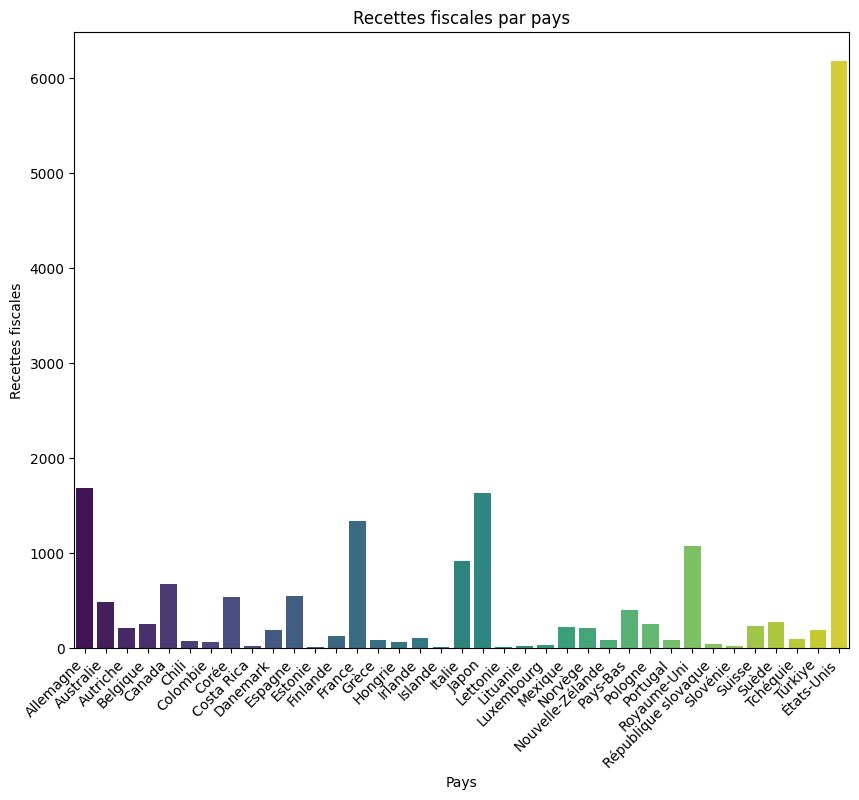

In [ ]:

plt.figure(figsize=(10, 8))
sns.barplot(data=df, x='Pays', y='Recettes fiscales', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Recettes fiscales par pays")
plt.ylabel("Recettes fiscales")
plt.xlabel("Pays")
plt.show()


**Interpr√©tation :**
- La taille des recettes fiscales est souvent corr√©l√©e √† la taille de l'√©conomie et √† la population d'un pays, ainsi qu'√† ses politiques fiscales.
- Les √âtats-Unis ont des recettes fiscales exceptionnellement √©lev√©es par rapport aux autres pays.
- Cela refl√®te l'importance de leur √©conomie, la taille de leur population, et leur syst√®me fiscal.
- Certains pays comme la France, le Japon et l'Allemagne ont des recettes fiscales significatives.
- Des pays comme la Colombie, l'Estonie, Islande ou la Slov√©nie ont des recettes fiscales beaucoup plus faibles, ce qui peut s'expliquer par des populations plus petites ou des √©conomies moins d√©velopp√©es.

**Analyse des donn√©es :**

**Existe-t-il une relation entre les recettes fiscales et le PIB ?**

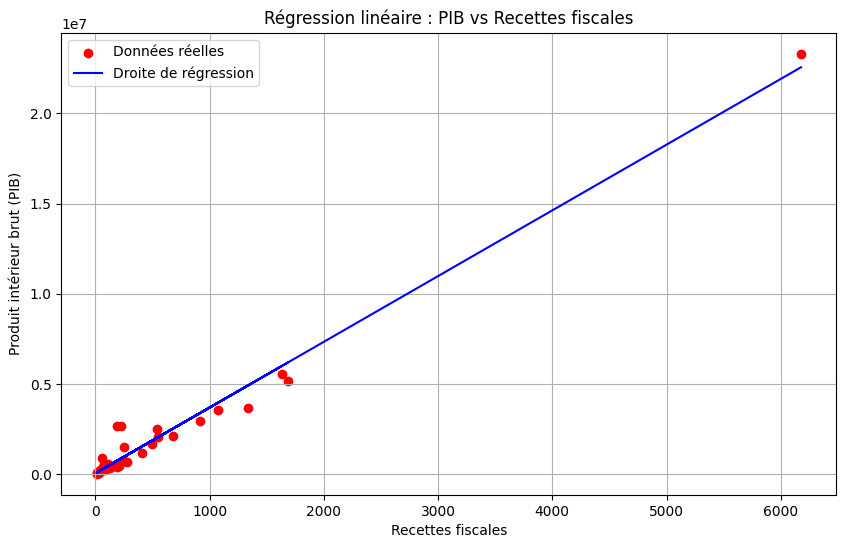

In [ ]:
y = df['Produit int√©rieur brut (PIB)']
X = df[['Recettes fiscales']]

X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()

y_pred = model.predict(X_const)

plt.figure(figsize=(10, 6))

plt.scatter(X, y, color='red', label='Donn√©es r√©elles')

plt.plot(X, y_pred, color='blue', label='Droite de r√©gression')

plt.xlabel('Recettes fiscales')
plt.ylabel('Produit int√©rieur brut (PIB)')
plt.title('R√©gression lin√©aire : PIB vs Recettes fiscales')
plt.legend()
plt.grid()

plt.show()


**Interpr√©tation :**

- Il existe une relation positive entre les recettes fiscales et le PIB : lorsque les recettes fiscales augmentent, le PIB tend √©galement √† augmenter.
- le groupe concentr√© montre une tendance g√©n√©rale dans les valeurs des PIB et recettes fiscales.
- La valeur extr√™me repr√©sente une observation particuli√®re o√π les recettes fiscales et le PIB sont tous deux tr√®s √©lev√©s.

- **Quelles sont les relations entre les diff√©rentes variables d√©mographiques ?**
- **Y a-t-il des groupes de pays ayant des profils d√©mographiques similaires ?**
- **Comment les pays se positionnent-ils les uns par rapport aux autres en termes de donn√©es d√©mographiques ?**

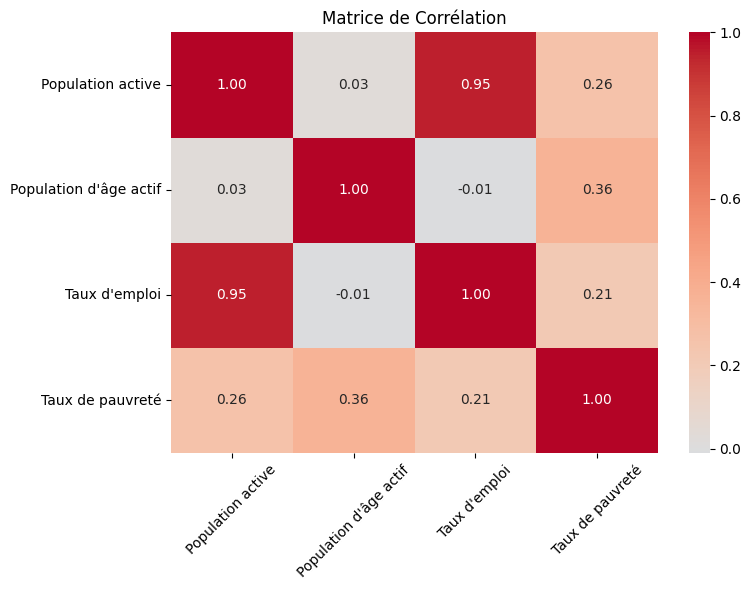

In [ ]:
# S√©lection des variables d√©mographiques
demo_vars = ['Population active', 'Population d\'√¢ge actif', 'Taux d\'emploi', 'Taux de pauvret√©']
df_cleaned = df[demo_vars].dropna()

# √âtape 1 : centrage-r√©duction des donn√©es
df_cleaned = df[demo_vars].dropna()
scaler = StandardScaler()
demo_data_scaled = scaler.fit_transform(df_cleaned)

# √âtape 2 : Matrice de Corr√©lation
corr_matrix = np.corrcoef(demo_data_scaled.T)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,
            annot=True,
            cmap="coolwarm",
            center=0,
            fmt=".2f",
            xticklabels=demo_vars,
            yticklabels=demo_vars)
plt.title("Matrice de Corr√©lation")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Interpr√©tation :**

- **Population d'√¢ge actif & Taux d'emploi** : Corr√©lation positive forte; cela indique que plus la population active est importante, plus le taux d'emploi est √©lev√©. Cela refl√®te une relation logique entre ces deux variables.
- **Population active & Taux de pauvret√©** : Corr√©lation faible et positive. Une augmentation de la population active est l√©g√®rement associ√©e √† une augmentation du taux de pauvret√©.
- **Population d'√¢ge actif & Taux de pauvret√©** : Corr√©lation positive mod√©r√©e. Une augmentation de la population d'√¢ge actif est associ√©e √† une augmentation mod√©r√©e du taux de pauvret√©.
- Les autres variables montrent des corr√©lations faibles .

In [ ]:
# √âtape 3 : Initialisation de l'ACP
pca = PCA(n_components=len(demo_vars))
demo_data_pca = pca.fit_transform(demo_data_scaled)

In [ ]:
# √âtape 4 : Proportions de variance expliqu√©e
explained_variance_ratio = pca.explained_variance_ratio_

print("Proportion de variance expliqu√©e par chaque composante principale :")
for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"Composante {i}: {ratio:.2%}")


Proportion de variance expliqu√©e par chaque composante principale :
Composante 1: 44.56%
Composante 2: 24.82%
Composante 3: 19.24%
Composante 4: 11.38%


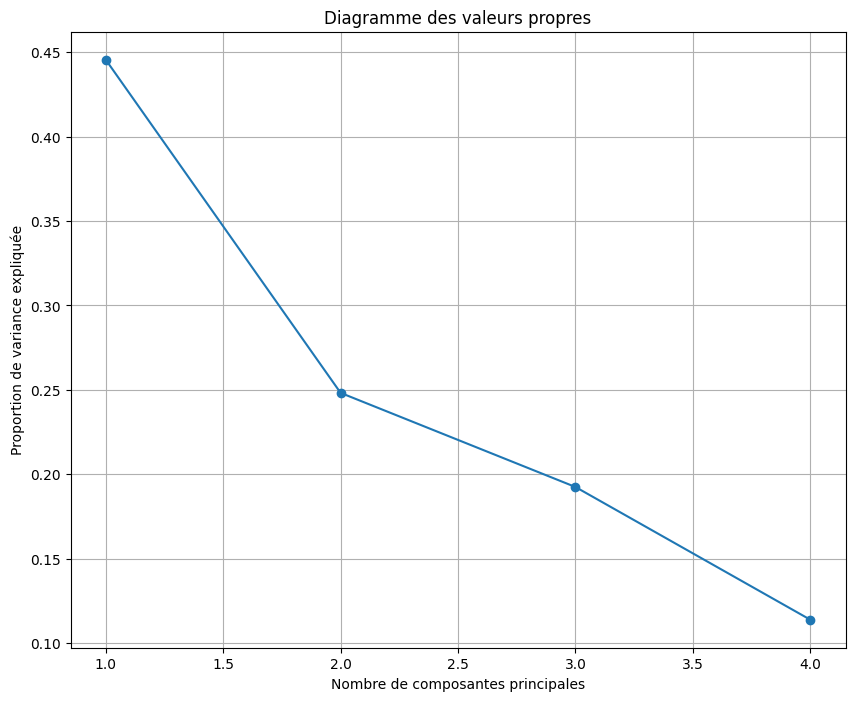

In [ ]:
# √âtape 5 : Trac√© du diagramme des valeurs propres
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de variance expliqu√©e')
plt.title('Diagramme des valeurs propres')
plt.grid()
plt.show()

**Interpr√©tation :**
- Le graphique montre un "coude" apr√®s la deuxi√®me composante. Cela indique que les deux premi√®res composantes principales sont les plus importantes pour expliquer la majorit√© de la variance dans les donn√©es (ils expliquent 69.38% de la variance totale).

Liste des pays utilis√©s : ['Autriche', 'Belgique', 'Canada', 'Cor√©e', 'Costa Rica', 'Espagne', 'Estonie', 'Finlande', 'France', 'Gr√®ce', 'Hongrie', 'Irlande', 'Italie', 'Lettonie', 'Lituanie', 'Luxembourg', 'Norv√®ge', 'Pays-Bas', 'Pologne', 'Portugal', 'Royaume-Uni', 'R√©publique slovaque', 'Slov√©nie', 'Su√®de', 'Tch√©quie', '√âtats-Unis']


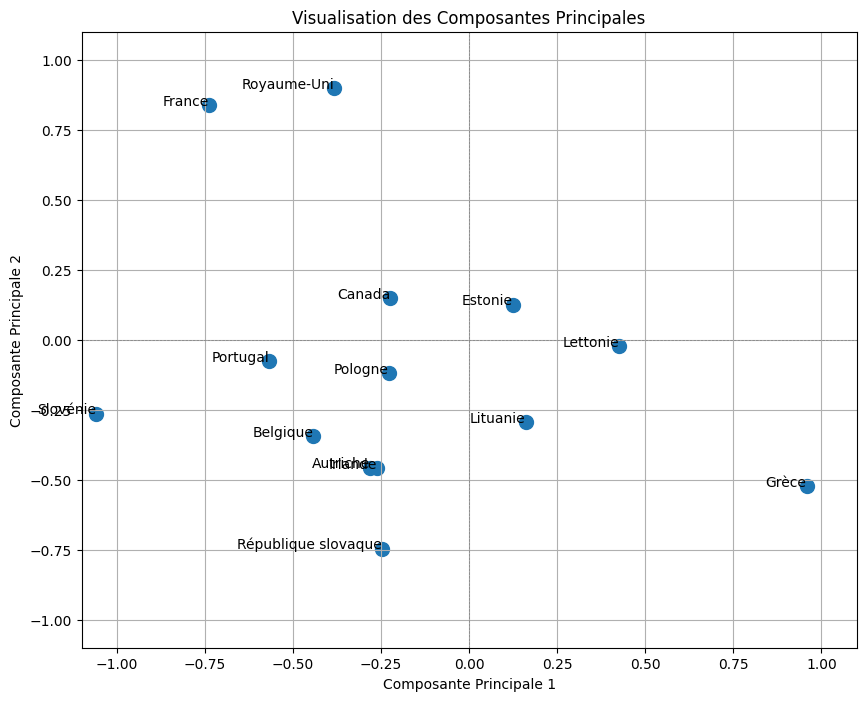

In [ ]:
# √âtape 6 : Visualisation des composantes principales avec les noms des pays
plt.figure(figsize=(10, 8))
plt.scatter(demo_data_pca[:, 0], demo_data_pca[:, 1], s=100)
pays_utilises = df['Pays'].iloc[df_cleaned.index].tolist()
print("Liste des pays utilis√©s :", pays_utilises)

for i in range(len(df_cleaned)):
    plt.annotate(df['Pays'].iloc[df_cleaned.index[i]],
                 (demo_data_pca[i, 0], demo_data_pca[i, 1]),
                 fontsize=10, ha='right')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Visualisation des Composantes Principales')
plt.grid()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()


**Interpr√©tation :**
- Les pays proches les uns des autres dans le graphique ont des profils similaires en termes des variables d√©mographiques.
- La France, Royaume-Unis,Slov√©nie et la Gr√®ce se d√©marquent des autres pays, sugg√©rant un profil d√©mographiques diff√©rent.


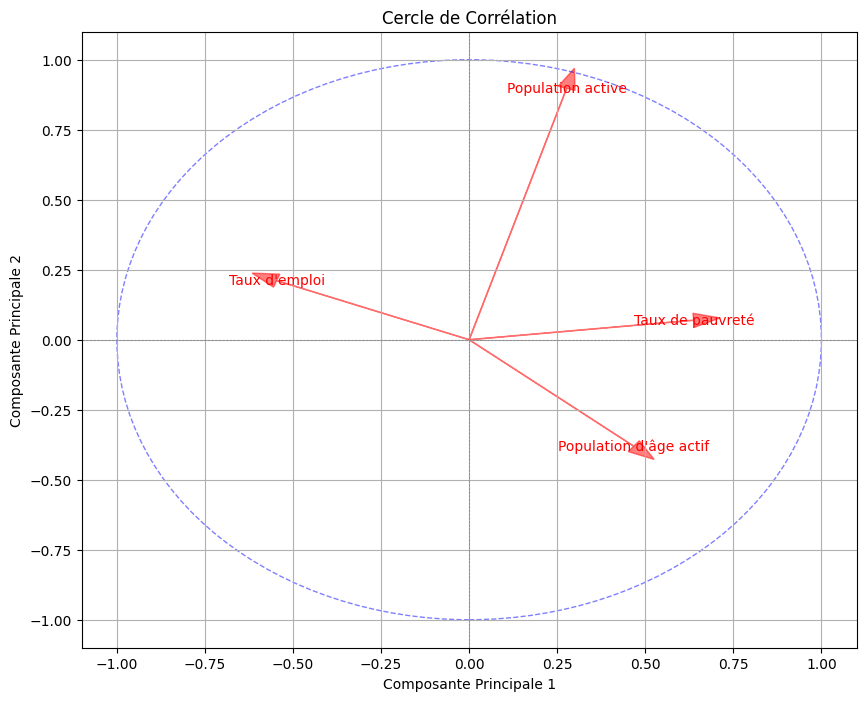

In [ ]:
from sklearn.decomposition import PCA
# √âtape 7 : Ajout du cercle de corr√©lation
components = pca.components_
components_to_plot = components.T[:, :2]

plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(components_to_plot):
    plt.arrow(0, 0, x, y, color='r', alpha=0.5, head_width=0.05)
    plt.text(x, y, demo_vars[i], color='r', ha='center', va='center')

circle = plt.Circle((0, 0), 1, color='b', fill=False, linestyle='--', alpha=0.5)
plt.gca().add_artist(circle)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Cercle de Corr√©lation')
plt.grid()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.show()

#Le cercle de corr√©lation permet d'identifier  les relations entre les variables,ce qui aide √† comprendre quels facteurs d√©mographiques influencent le plus les diff√©rences entre les pays.

**Interpr√©tation :**
- La population active influencent fortement la 2√®me composante.
- Le taux de pauvret√© indique une forte corr√©lation positive avec CP1.
- Le taux de pauvret√© et la population d‚Äô√¢ge actif sont corr√©l√©s.
- Population d‚Äô√¢ge actif et taux d‚Äôemploi  forment une corr√©lation n√©gative faible √† mod√©r√©e.


**Quels sont les groupes de pays ayant des profils √©conomiques similaires ?**

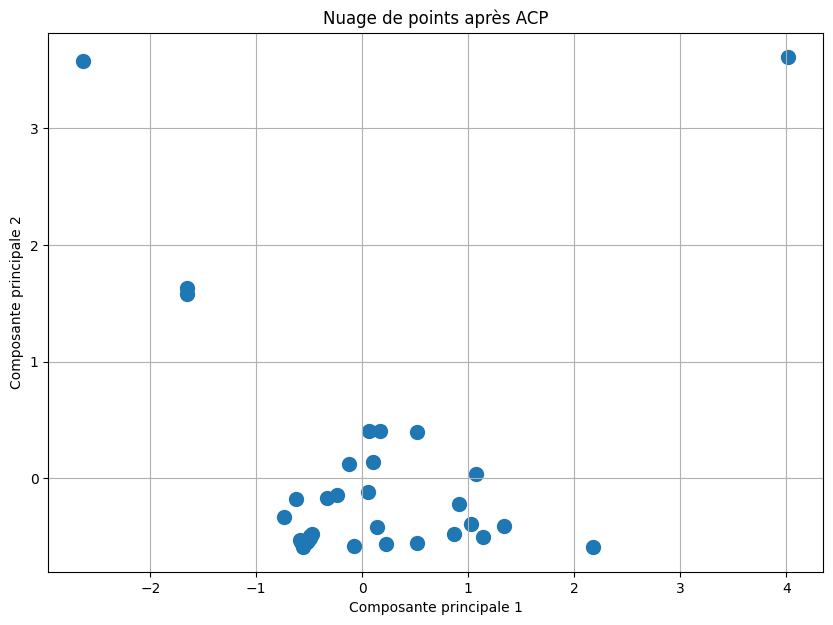

In [ ]:
selected_columns = ['D√©penses des administrations publiques',
                    'Produit int√©rieur brut (PIB)',
                    'Revenu national net']

selected_data = df[selected_columns]

selected_data = selected_data.fillna(selected_data.mean())

scaler = StandardScaler()
selected_data_scaled = scaler.fit_transform(selected_data)

pca = PCA(n_components=2)
selected_data_pca = pca.fit_transform(selected_data_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(selected_data_pca[:, 0], selected_data_pca[:, 1], s=100)
plt.title("Nuage de points apr√®s ACP")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid()
plt.show()


**Interpr√©tation :**
- Les pays regroup√©s ensemble peuvent partager des caract√©ristiques d√©mographiques similaires.
- On peut distinguer 4 groupes de donn√©es, c'est a dire que les pays peuvent √™tre regroup√©s en fonction de leur

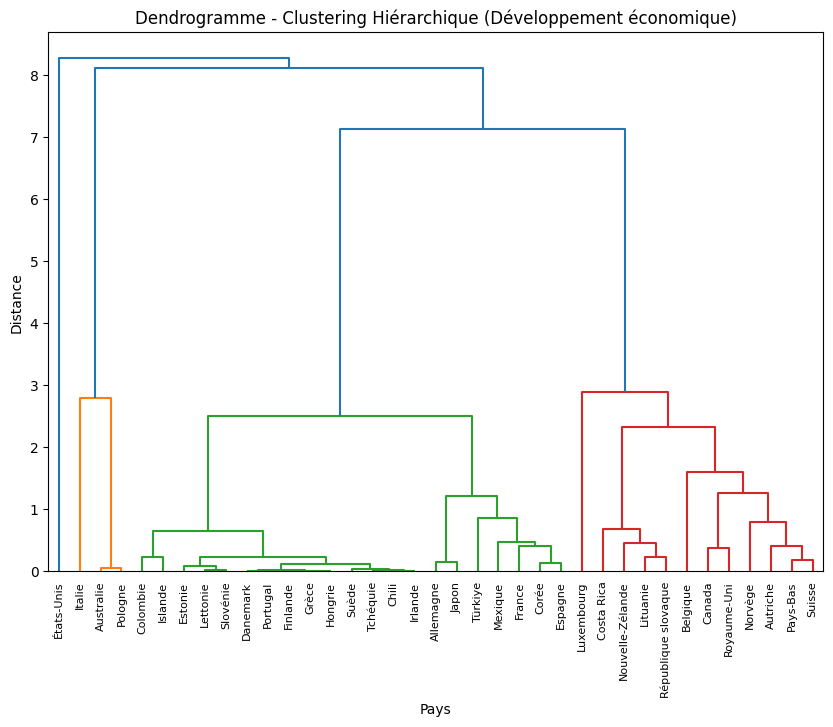

In [ ]:
# Clustering hi√©rarchique
linked = linkage(selected_data_scaled, method='ward')

plt.figure(figsize=(10, 7))
plt.title("Dendrogramme - Clustering Hi√©rarchique (D√©veloppement √©conomique)")
dendrogram(linked, labels=df['Pays'].tolist(), leaf_rotation=90)
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.show()

**Interpr√©tation :**
- Les pays les plus similaires apparaissent connect√©s par des branches proches.Comme dans le
    - Cluster Rouge : qui semble contenir des pays avec des caract√©ristiques socio-√©conomiques similaires, sugg√©rant qu'ils partagent des niveaux de d√©veloppement comparables.
    - Cluster Vert : qui repr√©sente des pays avec des diff√©rences marqu√©es, mais qui sont encore plus similaires entre eux.
    - Cluster Orange : √©tant plus √©loign√© des autres, pourrait repr√©senter des pays avec des caract√©ristiques socio-√©conomiques tr√®s distinctes.
- La grande distance entre les √âtats-Unis et les autres branches sugg√®re que les diff√©rences sont significatives

Trouver un nombre int√©ressant de clusters dans un dendrogramme revient √† identifier l'espace o√π les lignes verticales sont les plus longues. Cela indique une s√©paration plus marqu√©e entre les clusters.

On peut tracer une ligne horizontale qui passe par cette distance maximale :

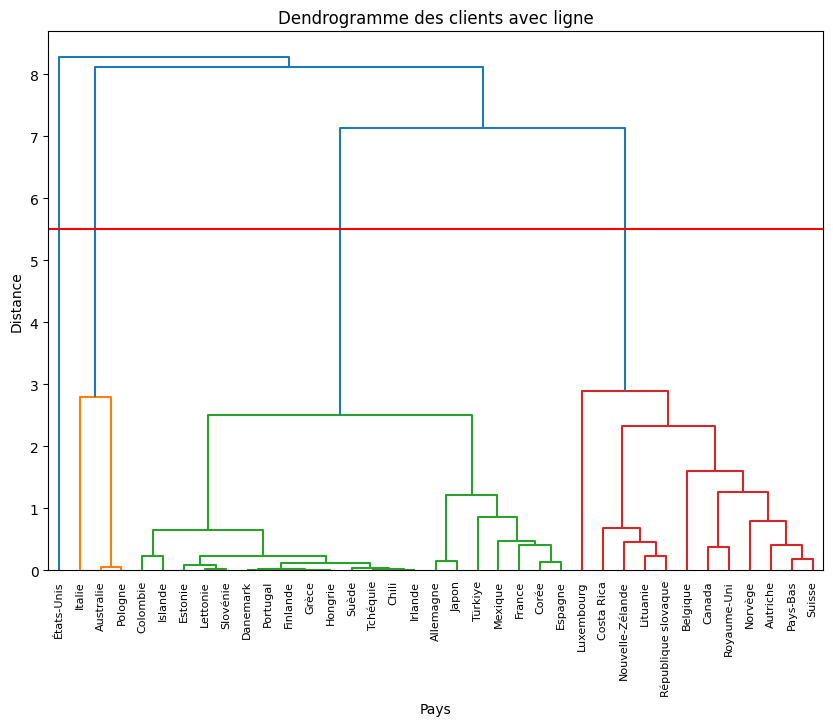

In [ ]:
## Determination des clusters :
plt.figure(figsize=(10, 7))
plt.title("Dendrogramme des clients avec ligne")
clusters = shc.linkage(selected_data_scaled, method='ward', metric="euclidean")
shc.dendrogram(clusters, labels=df['Pays'].tolist(), leaf_rotation=90)
plt.axhline(y=5.5, color='r', linestyle='-')
plt.xlabel("Pays")
plt.ylabel("Distance")
plt.show()


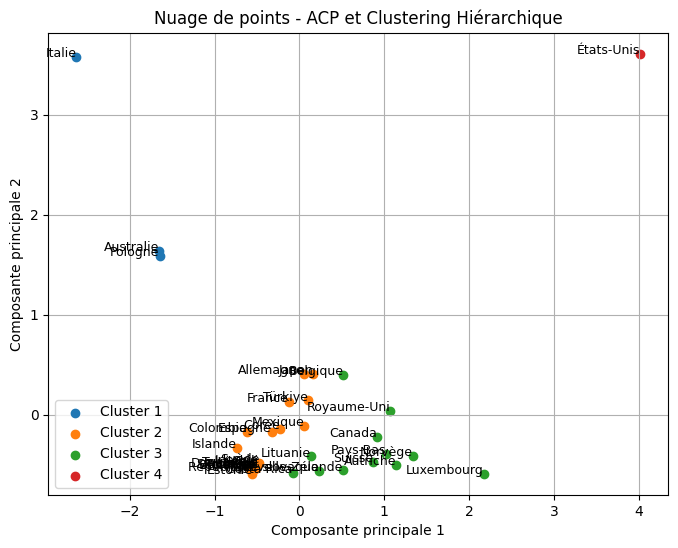

In [ ]:
num_clusters = 4
clusters_hierarchical = fcluster(linked, num_clusters, criterion='maxclust')

df['Cluster_Hierarchical'] = clusters_hierarchical

# Visualisation des clusters avec ACP
plt.figure(figsize=(8, 6))
for cluster in range(1, num_clusters + 1):
    cluster_data = selected_data_pca[clusters_hierarchical == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}')

    for i in range(len(cluster_data)):
        plt.annotate(df['Pays'][clusters_hierarchical == cluster].iloc[i],
                     (cluster_data[i, 0], cluster_data[i, 1]),
                     fontsize=9, ha='right')

plt.title("Nuage de points - ACP et Clustering Hi√©rarchique")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid()
plt.show()


**Interpr√©tation :**

- Les pays dans le m√™me cluster pourraient avoir des politiques fiscales et des structures √©conomiques comparables. 
- La dispersion des points peut indiquer une variabilit√© dans les politiques fiscales et les performances √©conomiques entre les pays.



## **3- World Bank API** :
## **√âconomie, √âducation et Emploi : Analyse des Indicateurs Mondiaux:**

**Le jeu de donn√©e √©tudi√© regroupe des donn√©es de 190 pays pour l'ann√©e 2021, issues de l'API de la Banque mondiale. Il inclut des indicateurs √©conomiques (PIB par habitant, emploi vuln√©rable), √©ducatifs (taux de scolarisation, d√©penses en √©ducation) et sociaux (d√©penses en sant√©), permettant d'explorer leurs relations avec l'Indice de D√©veloppement Humain (IDH).**

### Nettoyage des donn√©es :

**R√©cup√©ration des donn√©es**

In [ ]:
# Ann√©e cible
year = "2021"

# Indicateurs par domaine
indicators = {
    "economic": {
        "NY.GDP.PCAP.PP.CD": "PIB par habitant (PPA)",
        "NE.TRD.GNFS.ZS": "Commerce (% du PIB)",
    },
    "labor_market": {
        "SL.EMP.VULN.ZS": "Emploi vuln√©rable",
    },
    "education": {
        "SE.XPD.TOTL.GD.ZS": "D√©penses en √©ducation (% du PIB)",
        "SE.SEC.ENRR": "Scolarisation secondaire",
    },
    "health": {
        "SH.XPD.CHEX.GD.ZS": "D√©penses en sant√© (% du PIB)",
    }
}

# URL de base de l'API
base_url = "http://api.worldbank.org/v2/country/all/indicator/{}?date={}&format=json&per_page=10000"

# Fonction pour r√©cup√©rer les donn√©es d'un domaine
def fetch_data(domain_indicators):
    data = {}
    for indicator, description in domain_indicators.items():
        print(f"Collecte des donn√©es pour : {description}")
        url = base_url.format(indicator, year)
        response = requests.get(url)
        if response.status_code == 200:
            response_data = response.json()
            if len(response_data) > 1 and response_data[1] is not None:
                for entry in response_data[1]:
                    country_name = entry.get("country", {}).get("value")
                    value = entry.get("value")
                    if country_name not in data:
                        data[country_name] = {}
                    data[country_name][description] = value
        else:
            print(f"Erreur pour l'indicateur {description}")
    return pd.DataFrame.from_dict(data, orient="index")

# R√©cup√©rer les donn√©es pour chaque domaine
economic_df = fetch_data(indicators["economic"])
labor_market_df = fetch_data(indicators["labor_market"])
education_df = fetch_data(indicators["education"])
health_df = fetch_data(indicators["health"])

# Combiner toutes les donn√©es dans un seul DataFrame
final_df = pd.concat([economic_df, labor_market_df, education_df, health_df], axis=1)

# Afficher les premi√®res lignes du DataFrame final
print(final_df.head())

Collecte des donn√©es pour : PIB par habitant (PPA)
Collecte des donn√©es pour : Commerce (% du PIB)
Collecte des donn√©es pour : Emploi vuln√©rable
Collecte des donn√©es pour : D√©penses en √©ducation (% du PIB)
Collecte des donn√©es pour : Scolarisation secondaire
Collecte des donn√©es pour : D√©penses en sant√© (% du PIB)
                                PIB par habitant (PPA)  Commerce (% du PIB)  \
Africa Eastern and Southern                3907.951637            55.562396   
Africa Western and Central                 4698.926894                  NaN   
Arab World                                15534.523797            81.561982   
Caribbean small states                    20001.269738                  NaN   
Central Europe and the Baltics            40579.087951           125.533293   

                                Emploi vuln√©rable  \
Africa Eastern and Southern             72.727499   
Africa Western and Central              80.506941   
Arab World                            

**Remplissage des valeurs manquantes par la mediane**

In [ ]:
# Remplissage des valeurs manquantes
economic_df = economic_df.fillna(economic_df.median(numeric_only=True))
labor_market_df = labor_market_df.fillna(labor_market_df.median(numeric_only=True))
education_df = education_df.fillna(education_df.median(numeric_only=True))
health_df = health_df.fillna(health_df.median(numeric_only=True))

**R√©initialisation de l'index et Sauvegarde des datasets**

In [ ]:
# R√©initialiser l'index pour inclure les noms des pays comme colonne
economic_df.reset_index(inplace=True)
labor_market_df.reset_index(inplace=True)
education_df.reset_index(inplace=True)
health_df.reset_index(inplace=True)


# Renommer l'index r√©initialis√© en "Pays"
economic_df.rename(columns={"index": "Pays"}, inplace=True)
labor_market_df.rename(columns={"index": "Pays"}, inplace=True)
education_df.rename(columns={"index": "Pays"}, inplace=True)
health_df.rename(columns={"index": "Pays"}, inplace=True)


# Sauvegarde des datasets individuels
economic_df.to_csv("eco.csv", index=False)
labor_market_df.to_csv("emp.csv", index=False)
education_df.to_csv("edu.csv", index=False)
health_df.to_csv("health.csv",index=False)

**Fusionnage des datasets et Exportation du dataset fusionn√©**

In [ ]:
# Fusion des datasets sur les noms des pays
merged_df = economic_df.merge(labor_market_df, on="Pays", how="outer")
merged_df = merged_df.merge(education_df, on="Pays", how="outer")
merged_df = merged_df.merge(health_df, on="Pays", how="outer")


# Sauvegarde du dataset complet
merged_df.to_csv("complete_dataset.csv", index=False)
print("Dataset complet sauvegard√© sous 'complete_dataset.csv'")


Dataset complet sauvegard√© sous 'complete_dataset.csv'


**Exclure les rassemblements et garder les pays**

In [ ]:
# Charger le jeu de donn√©es
df = pd.read_csv('complete_dataset.csv')

# Liste des noms de pays √† exclure
excluded_countries = [
    "Sub-Saharan Africa",
    "Arab World",
    "High income",
    "Low income",
    "OECD members",
    "Fragile and conflict affected situations",
    "Other small states",
    "Europe & Central Asia",
    "Latin America & the Caribbean",
    "Africa Eastern and Southern",
    "Africa Western and Central",
    "Caribbean small states",
    "Central Europe and the Baltics",
    "Early-demographic dividend",
    "East Asia & Pacific",
    "East Asia & Pacific (IDA & IBRD countries)",
    "East Asia & Pacific (excluding high income)",
    "Europe & Central Asia (IDA & IBRD countries)",
    "Europe & Central Asia (excluding high income)",
    "European Union",
    "Fragile and conflict affected situations",
    "Heavily indebted poor countries (HIPC)",
    "High income",
    "IBRD only",
    "IDA & IBRD total",
    "IDA blend",
    "IDA only",
    "IDA total",
    "Late-demographic dividend",
    "Latin America & Caribbean",
    "Latin America & Caribbean (excluding high income)",
    "Latin America & the Caribbean (IDA & IBRD countries)",
    "Least developed countries: UN classification",
    "Low & middle income",
    "Lower middle income",
    "Middle East & North Africa",
    "Middle East & North Africa (IDA & IBRD countries)",
    "Middle East & North Africa (excluding high income)",
    "Middle income",
    "North America",
    "Pacific island small states",
    "Post-demographic dividend",
    "Pre-demographic dividend",
    "Small states",
    "South Asia",
    "South Asia (IDA & IBRD)",
    "Sub-Saharan Africa (IDA & IBRD countries)",
    "Sub-Saharan Africa (excluding high income)",
    "Upper middle income",
    "World"
]

# Filtrer le dataframe pour exclure ces groupes
filtered_df = df[~df['Pays'].isin(excluded_countries)]

# Sauvegarder le jeu de donn√©es filtr√©
filtered_df.to_csv("filtered_dataset.csv", index=False)
print("Jeu de donn√©es filtr√© enregistr√© sous le nom 'filtered_dataset.csv''")

Jeu de donn√©es filtr√© enregistr√© sous le nom 'filtered_dataset.csv''


**Mappage des noms de pays non conformes en noms reconnus**

In [ ]:
# Charger le jeu de donn√©es
file_path = 'filtered_dataset.csv'
df = pd.read_csv(file_path)

# Mappage des noms de pays non conformes en noms reconnus
rename_mapping = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam":"Brunei",
    "Congo, Dem. Rep.": "Congo (Democratic Republic)",
    "Congo, Rep.": "Congo (Congo-Brazzaville)",
    "Cote d'Ivoire": "Ivory Coast",
    "Egypt, Arab Rep.": "Egypt",
    "Eswatini": "Swaziland",
    "Gambia, The": "Gambia",
    "Hong Kong SAR, China": "Hong Kong",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Dem. People's Rep.": "North Korea",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Macao SAR, China": "Macau",
    "Micronesia, Fed. Sts.": "Micronesia",
    "Myanmar": "Myanmar (Burma)",
    "Slovak Republic": "Slovakia",
    "Syrian Arab Republic": "Syria",
    "Turkiye": "Turkey",
    "Venezuela, RB": "Venezuela",
    "Viet Nam": "Vietnam",
    "Virgin Islands (U.S.)": "United States Virgin Islands",
    "West Bank and Gaza": "Palestine",
    "Yemen, Rep.": "Yemen",
    "Czechia": "Czechia (Czech Republic)",
    "Russian Federation": "Russia",
    "St. Lucia" : "Saint Lucia",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "United States": "United States of America"
}

# Appliquer le renommage
df['Pays'] = df['Pays'].replace(rename_mapping)

**Garde les pays reconnus par les nations unies**

In [ ]:
# Liste des pays reconnus par les nations unies
recognized_countries = [
    "Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua and Barbuda", "Argentina", "Armenia",
    "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium",
    "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia and Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria",
    "Burkina Faso", "Burundi", "Cabo Verde", "Cambodia", "Cameroon", "Canada", "Central African Republic", "Chad",
    "Chile", "China", "Colombia", "Comoros", "Congo (Democratic Republic)", "Congo (Congo-Brazzaville)",
    "Costa Rica", "Ivory Coast", "Croatia", "Cuba", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Djibouti",
    "Dominica", "Dominican Republic", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia",
    "Swaziland", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece",
    "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India",
    "Indonesia", "Iran", "Iraq", "Ireland", "Italy", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya",
    "Kiribati", "North Korea", "South Korea", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho",
    "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Madagascar", "Malawi", "Malaysia", "Maldives",
    "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco",
    "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar (Burma)", "Namibia", "Nauru", "Nepal", "Netherlands",
    "New Zealand", "Nicaragua", "Niger", "Nigeria", "North Macedonia", "Norway", "Oman", "Pakistan", "Palau",
    "Palestine", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal",
    "Qatar", "Romania", "Russia", "Rwanda", "Samoa", "San Marino", "Sao Tome and Principe", "Saudi Arabia",
    "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands",
    "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka", "Saint Kitts and Nevis", "Saint Lucia",
    "Saint Vincent and the Grenadines", "Sudan", "Suriname", "Sweden", "Switzerland", "Syria", "Tajikistan",
    "Tanzania", "Thailand", "Timor-Leste", "Togo", "Tonga", "Trinidad and Tobago", "Tunisia", "Turkey",
    "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States of America",
    "Uruguay", "Uzbekistan", "Vanuatu","Yemen", "Venezuela", "Vietnam", "Zambia", "Zimbabwe"
]

# Garder uniquement les pays reconnus
df = df[df['Pays'].isin(recognized_countries)]

# Sauvegarder le jeu de donn√©es nettoy√©
cleaned_file_path = 'cleaned_dataset.csv'
df.to_csv(cleaned_file_path, index=False)

print(f"Jeu de donn√©es nettoy√© enregistr√© sous {cleaned_file_path}")


Jeu de donn√©es nettoy√© enregistr√© sous cleaned_dataset.csv


**Regroupement G√©ographique des Pays**

In [ ]:
# Charger le jeu de donn√©es
merged_df = pd.read_csv('cleaned_dataset.csv')

# Dictionnaire des r√©gions g√©ographiques par pays
region_dict = {
    "Afrique": [
        "Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon",
        "Central African Republic", "Chad", "Comoros", "Congo (Democratic Republic)", "Congo (Congo-Brazzaville)",
        "Ivory Coast", "Djibouti", "Egypt", "Equatorial Guinea", "Eritrea", "Swaziland", "Ethiopia",
        "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Libya",
        "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Morocco", "Mozambique", "Namibia",
        "Niger", "Nigeria", "Rwanda", "Sao Tome and Principe", "Senegal", "Seychelles", "Sierra Leone",
        "Somalia", "South Africa", "South Sudan", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda",
        "Zambia", "Zimbabwe"
    ],
    "Am√©riques": [
        "Argentina", "Aruba","Antigua and Barbuda","Barbados","Bahamas","Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica",
        "Cuba", "Curacao", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada",
        "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama",
        "Paraguay", "Peru", "Puerto Rico", "Saint Lucia", "Suriname", "Trinidad and Tobago",
        "United States of America", "Uruguay", "Venezuela","Saint Kitts and Nevis","Saint Vincent and the Grenadines"
    ],
    "Europe": [
        "Albania", "Andorra", "Armenia", "Austria", "Belarus", "Belgium", "Bosnia and Herzegovina",
        "Bulgaria", "Croatia", "Cyprus", "Czechia (Czech Republic)", "Denmark", "Estonia", "Finland", "France", "Georgia",
        "Germany", "Gibraltar", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", "Latvia",
        "Liechtenstein", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro",
        "Netherlands", "Norway","North Macedonia", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia",
        "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Ukraine", "United Kingdom"
    ],
    "Asie": [
        "Afghanistan", "Azerbaijan", "Bahrain", "Bangladesh", "Bhutan","Brunei", "Cambodia", "China",
        "India", "Indonesia", "Iran", "Iraq", "Israel", "Japan", "Jordan", "Kazakhstan", "Kuwait",
        "Kyrgyzstan", "Laos", "Lebanon", "Malaysia", "Maldives", "Mongolia", "Myanmar (Burma)", "Nepal",
        "North Korea", "Oman","Palestine", "Pakistan", "Philippines", "Qatar", "Saudi Arabia", "Singapore",
        "South Korea", "Sri Lanka", "Syria", "Tajikistan", "Thailand", "Timor-Leste", "Turkey",
        "Turkmenistan", "United Arab Emirates", "Uzbekistan", "Vietnam", "Yemen"
    ],
    "Oc√©anie": [
        "Australia", "Fiji", "Kiribati", "Marshall Islands", "Micronesia", "Nauru", "New Zealand",
        "Palau", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Tuvalu", "Vanuatu"
    ]
}


**Ajout des R√©gions G√©ographiques aux Pays**

In [ ]:
# Fonction pour assigner un pays √† sa r√©gion g√©ographique
def assign_region(country_name):
    for region, countries in region_dict.items():
        if country_name in countries:
            return region
    return "Inconnu"  # Si le pays n'est pas trouv√©

# Ajouter la colonne de r√©gion g√©ographique au dataframe
merged_df["R√©gion g√©ographique"] = merged_df["Pays"].apply(assign_region)

# Sauvegarder le dataset avec la nouvelle colonne
merged_df.to_csv("complete_dataset_with_regions.csv", index=False)
print("Dataset avec r√©gions g√©ographiques sauvegard√© sous 'complete_dataset_with_regions.csv'")


Dataset avec r√©gions g√©ographiques sauvegard√© sous 'complete_dataset_with_regions.csv'


**R√©cup√©ration des Donn√©es de l'Indice de D√©veloppement Humain (IDH) de UNDP**

In [ ]:
#r√©cup√©ration des donn√©es de UNDP (Indice de d√©veloppement humain IDH)
idh_url = "https://hdr.undp.org/data-center/documentation-and-downloads"
output_file = "hdr-data.csv"

# Charger le jeu de donn√©es
hdr_data = pd.read_csv('hdr-data.csv')

hdr_data.head()

countryIsoCode               country indexCode                    index  \
0            AFG           Afghanistan       HDI  Human Development Index   
1            AGO                Angola       HDI  Human Development Index   
2            ALB               Albania       HDI  Human Development Index   
3            AND               Andorra       HDI  Human Development Index   
4            ARE  United Arab Emirates       HDI  Human Development Index   

   dimension indicatorCode                        indicator  year  value  note  
0        NaN           hdi  Human Development Index (value)  2021  0.473   NaN  
1        NaN           hdi  Human Development Index (value)  2021  0.590   NaN  
2        NaN           hdi  Human Development Index (value)  2021  0.785   NaN  
3        NaN           hdi  Human Development Index (value)  2021  0.855   NaN  
4        NaN           hdi  Human Development Index (value)  2021  0.931   NaN

**Suppression des colonnes inutiles**

In [ ]:
# Suppression des colonnes inutiles
hdi_data_cleaned = hdr_data.drop(columns=[
    'countryIsoCode', 'indexCode', 'index', 'dimension', 'indicatorCode','indicator','year','note',
])

**Renommage des colonnes et v√©rification**

In [ ]:
# Renommer les colonnes pour une meilleure clart√©
hdi_data_cleaned.rename(columns={
    'country': 'Pays',
    'value': 'Indice de d√©veloppement humain (IDH)'
}, inplace=True)

# V√©rification des donn√©es apr√®s traitement
hdi_data_cleaned.head()

Pays  Indice de d√©veloppement humain (IDH)
0           Afghanistan                                 0.473
1                Angola                                 0.590
2               Albania                                 0.785
3               Andorra                                 0.855
4  United Arab Emirates                                 0.931

**Mappage des noms de pays non conformes en noms reconnus**

In [ ]:
# Dictionnaire pour mapper les noms incorrects aux noms corrects
country_name_mapping = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Congo": "Congo (Congo-Brazzaville)",
    "Congo (Democratic Republic of the)": "Congo (Democratic Republic)",
    "Czechia": "Czechia (Czech Republic)",
    "C√¥te d'Ivoire": "Ivory Coast",
    "Eswatini (Kingdom of)": "Swaziland",
    "Hong Kong, China (SAR)": "Hong Kong",
    "Iran (Islamic Republic of)": "Iran",
    "Korea (Republic of)": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    "Micronesia (Federated States of)": "Micronesia",
    "Moldova (Republic of)": "Moldova",
    "Myanmar": "Myanmar (Burma)",
    "Palestine, State of": "Palestine",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Tanzania (United Republic of)": "Tanzania",
    "United States": "United States of America",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam",
    "Yemen": "Yemen"
}

# Remplacer les noms de pays incorrects par les noms corrects
hdi_data_cleaned['Pays'] = hdi_data_cleaned['Pays'].replace(country_name_mapping)

# Enregistrer le DataFrame mis √† jour dans un nouveau fichier CSV
hdi_data_cleaned.to_csv('hdi_data_cleaned.csv', index=False)

print("Les noms de pays ont √©t√© mis √† jour et enregistr√©s dans 'hdi_data_cleaned.csv'.")

Les noms de pays ont √©t√© mis √† jour et enregistr√©s dans 'hdi_data_cleaned.csv'.


**Fusionnage des datasets(ajout de IDH)**

In [ ]:
idh_df = pd.read_csv("hdi_data_cleaned.csv")

merged_df = merged_df.merge(idh_df[["Pays", "Indice de d√©veloppement humain (IDH)"]], on="Pays", how="outer")

**Suppression des lignes avec des valeurs nulles**

In [ ]:
# Liste des lignes qui contient des valeurs nulles
countries_to_remove = ["Monaco", "North Korea", "Somalia", "Hong Kong", "Israel"]

# supprimer les lignes qui contient des valeurs nulles
merged_df = merged_df[~merged_df['Pays'].isin(countries_to_remove)].dropna()

# Sauvegarde finale
merged_df.to_csv("updated_dataset.csv", index=False)
print("Dataset mis √† jour sauvegard√© sous 'updated_dataset.csv'")


Dataset mis √† jour sauvegard√© sous 'updated_dataset.csv'


**Classification des pays selon Niveau de D√©veloppement**

In [ ]:
# V√©rifiez que la colonne 'Indice de d√©veloppement humain (IDH)' existe
if "Indice de d√©veloppement humain (IDH)" in merged_df.columns:
    # Ajout de la colonne 'Niveau de d√©veloppement' bas√© sur les cat√©gories
    def classify_hdi(hdi):
        if hdi >= 0.8:
            return "IDH tr√®s √©lev√©"
        elif 0.7 <= hdi < 0.8:
            return "IDH √©lev√©"
        elif 0.5 <= hdi < 0.7:
            return "IDH moyen"
        else:
            return "IDH faible"

    merged_df["Niveau de d√©veloppement"] = merged_df["Indice de d√©veloppement humain (IDH)"].apply(classify_hdi)

    # Sauvegarder le fichier mis √† jour
    output_file = "last_dataset.csv"
    merged_df.to_csv(output_file, index=False)
    print(f"Le fichier mis √† jour avec les niveaux de d√©veloppement a √©t√© sauvegard√© sous '{output_file}'.")
else:
    print("La colonne 'Indice de d√©veloppement humain (IDH)' n'existe pas dans les donn√©es.")


Le fichier mis √† jour avec les niveaux de d√©veloppement a √©t√© sauvegard√© sous 'last_dataset.csv'.


**Organisation des colonnes et Exportation du jeu de donn√©es**

In [ ]:
# D√©finir le nouvel ordre des colonnes
nouvel_ordre = [
    'Pays', 'PIB par habitant (PPA)',
    'Commerce (% du PIB)','Emploi vuln√©rable','D√©penses en sant√© (% du PIB)',
    'D√©penses en √©ducation (% du PIB)', 'Scolarisation secondaire','Indice de d√©veloppement humain (IDH)',
    'Niveau de d√©veloppement','R√©gion g√©ographique',
]

# R√©organiser les colonnes
merged_df = merged_df[nouvel_ordre]

# Sauvegarder le dataset final ordonn√©
output_path = 'last_dataset_updated.csv'
merged_df.to_csv(output_path, index=False)

print("Le dataset a √©t√© r√©organis√© et sauvegard√©.")

Le dataset a √©t√© r√©organis√© et sauvegard√©.


In [ ]:
# Dictionnaire complet qui fait correspondre les noms de pays en anglais aux noms en fran√ßais
country_translations = {
    "Afghanistan": "Afghanistan",
    "Albania": "Albanie",
    "Algeria": "Alg√©rie",
    "Andorra": "Andorre",
    "Angola": "Angola",
    "Antigua and Barbuda": "Antigua-et-Barbuda",
    "Argentina": "Argentine",
    "Armenia": "Arm√©nie",
    "Australia": "Australie",
    "Austria": "Autriche",
    "Azerbaijan": "Azerba√Ødjan",
    "Bahamas": "Bahamas",
    "Bahrain": "Bahre√Øn",
    "Bangladesh": "Bangladesh",
    "Barbados": "Barbade",
    "Belarus": "Bi√©lorussie",
    "Belgium": "Belgique",
    "Belize": "Belize",
    "Benin": "B√©nin",
    "Bhutan": "Bhoutan",
    "Bolivia": "Bolivie",
    "Bosnia and Herzegovina": "Bosnie-Herz√©govine",
    "Botswana": "Botswana",
    "Brazil": "Br√©sil",
    "Brunei": "Brunei",
    "Bulgaria": "Bulgarie",
    "Burkina Faso": "Burkina Faso",
    "Burundi": "Burundi",
    "Cabo Verde": "Cap-Vert",
    "Cambodia": "Cambodge",
    "Cameroon": "Cameroun",
    "Canada": "Canada",
    "Central African Republic": "R√©publique Centrafricaine",
    "Chad": "Tchad",
    "Chile": "Chili",
    "China": "Chine",
    "Colombia": "Colombie",
    "Comoros": "Comores",
    "Congo (Congo-Brazzaville)": "Congo (Congo-Brazzaville)",
    "Congo (Democratic Republic)": "Congo (R√©publique D√©mocratique)",
    "Costa Rica": "Costa Rica",
    "Croatia": "Croatie",
    "Cuba": "Cuba",
    "Cyprus": "Chypre",
    "Czechia (Czech Republic)": "R√©publique Tch√®que",
    "Denmark": "Danemark",
    "Djibouti": "Djibouti",
    "Dominica": "Dominique",
    "Dominican Republic": "R√©publique Dominicaine",
    "Ecuador": "√âquateur",
    "Egypt": "√âgypte",
    "El Salvador": "El Salvador",
    "Equatorial Guinea": "Guin√©e √âquatoriale",
    "Eritrea": "√ârythr√©e",
    "Estonia": "Estonie",
    "Ethiopia": "√âthiopie",
    "Fiji": "Fidji",
    "Finland": "Finlande",
    "France": "France",
    "Gabon": "Gabon",
    "Gambia": "Gambie",
    "Georgia": "G√©orgie",
    "Germany": "Allemagne",
    "Ghana": "Ghana",
    "Greece": "Gr√®ce",
    "Grenada": "Grenade",
    "Guatemala": "Guatemala",
    "Guinea": "Guin√©e",
    "Guinea-Bissau": "Guin√©e-Bissau",
    "Guyana": "Guyana",
    "Haiti": "Ha√Øti",
    "Honduras": "Honduras",
    "Hungary": "Hongrie",
    "Iceland": "Islande",
    "India": "Inde",
    "Indonesia": "Indon√©sie",
    "Iran": "Iran",
    "Iraq": "Irak",
    "Ireland": "Irlande",
    "Israel": "Isra√´l",
    "Italy": "Italie",
    "Ivory Coast": "C√¥te d'Ivoire",
    "Jamaica": "Jama√Øque",
    "Japan": "Japon",
    "Jordan": "Jordanie",
    "Kazakhstan": "Kazakhstan",
    "Kenya": "Kenya",
    "Kiribati": "Kiribati",
    "Kuwait": "Kowe√Øt",
    "Kyrgyzstan": "Kirghizistan",
    "Laos": "Laos",
    "Latvia": "Lettonie",
    "Lebanon": "Liban",
    "Lesotho": "Lesotho",
    "Liberia": "Lib√©ria",
    "Libya": "Libye",
    "Liechtenstein": "Liechtenstein",
    "Lithuania": "Lituanie",
    "Luxembourg": "Luxembourg",
    "Madagascar": "Madagascar",
    "Malawi": "Malawi",
    "Malaysia": "Malaisie",
    "Maldives": "Maldives",
    "Mali": "Mali",
    "Malta": "Malte",
    "Marshall Islands": "√éles Marshall",
    "Mauritania": "Mauritanie",
    "Mauritius": "Maurice",
    "Mexico": "Mexique",
    "Micronesia": "Micron√©sie",
    "Moldova": "Moldavie",
    "Monaco": "Monaco",
    "Mongolia": "Mongolie",
    "Montenegro": "Mont√©n√©gro",
    "Morocco": "Maroc",
    "Mozambique": "Mozambique",
    "Myanmar (Burma)": "Myanmar (Birmanie)",
    "Namibia": "Namibie",
    "Nauru": "Nauru",
    "Nepal": "N√©pal",
    "Netherlands": "Pays-Bas",
    "New Zealand": "Nouvelle-Z√©lande",
    "Nicaragua": "Nicaragua",
    "Niger": "Niger",
    "Nigeria": "Nig√©ria",
    "North Macedonia": "Mac√©doine du Nord",
    "Norway": "Norv√®ge",
    "Oman": "Oman",
    "Pakistan": "Pakistan",
    "Palau": "Palaos",
    "Palestine": "Palestine",
    "Panama": "Panama",
    "Papua New Guinea": "Papouasie-Nouvelle-Guin√©e",
    "Paraguay": "Paraguay",
    "Peru": "P√©rou",
    "Philippines": "Philippines",
    "Poland": "Pologne",
    "Portugal": "Portugal",
    "Qatar": "Qatar",
    "Romania": "Roumanie",
    "Russia": "Russie",
    "Rwanda": "Rwanda",
    "Saint Kitts and Nevis": "Saint-Kitts-et-Nevis",
    "Saint Lucia": "Sainte-Lucie",
    "Saint Vincent and the Grenadines": "Saint-Vincent-et-les-Grenadines",
    "Samoa": "Samoa",
    "San Marino": "Saint-Marin",
    "Sao Tome and Principe": "Sao Tom√©-et-Principe",
    "Saudi Arabia": "Arabie Saoudite",
    "Senegal": "S√©n√©gal",
    "Serbia": "Serbie",
    "Seychelles": "Seychelles",
    "Sierra Leone": "Sierra Leone",
    "Singapore": "Singapour",
    "Slovakia": "Slovaquie",
    "Slovenia": "Slov√©nie",
    "Solomon Islands": "√éles Salomon",
    "South Africa": "Afrique du Sud",
    "South Korea": "Cor√©e du Sud",
    "South Sudan": "Soudan du Sud",
    "Spain": "Espagne",
    "Sri Lanka": "Sri Lanka",
    "Sudan": "Soudan",
    "Suriname": "Suriname",
    "Swaziland": "Swaziland",
    "Sweden": "Su√®de",
    "Switzerland": "Suisse",
    "Syria": "Syrie",
    "Tajikistan": "Tadjikistan",
    "Tanzania": "Tanzanie",
    "Thailand": "Tha√Ølande",
    "Timor-Leste": "Timor-Leste",
    "Togo": "Togo",
    "Tonga": "Tonga",
    "Trinidad and Tobago": "Trinit√©-et-Tobago",
    "Tunisia": "Tunisie",
    "Turkey": "Turquie",
    "Turkmenistan": "Turkm√©nistan",
    "Tuvalu": "Tuvalu",
    "Uganda": "Ouganda",
    "Ukraine": "Ukraine",
    "United Arab Emirates": "√âmirats Arabes Unis",
    "United Kingdom": "Royaume-Uni",
    "United States of America": "√âtats-Unis",
    "Uruguay": "Uruguay",
    "Uzbekistan": "Ouzb√©kistan",
    "Vanuatu": "Vanuatu",
    "Venezuela": "Venezuela",
    "Vietnam": "Vietnam",
    "Yemen": "Y√©men",
    "Zambia": "Zambie",
    "Zimbabwe": "Zimbabwe"
}

# Ouvrir le fichier CSV et lire le contenu
with open('last_dataset_updated.csv', mode='r', encoding='utf-8') as file:
    csv_reader = csv.DictReader(file)

    # Traduire les noms de pays en fran√ßais
    translated_rows = []

    for row in csv_reader:
        country_name = row['Pays']
        if country_name in country_translations:
            row['Pays'] = country_translations[country_name]
        translated_rows.append(row)

# Sauvegarder les lignes traduites dans un nouveau fichier CSV
with open('final_data.csv', mode='w', encoding='utf-8', newline='') as file:
    fieldnames = csv_reader.fieldnames
    csv_writer = csv.DictWriter(file, fieldnames=fieldnames)

    csv_writer.writeheader()

    for row in translated_rows:
        csv_writer.writerow(row)

print("Les noms de pays ont √©t√© traduits et enregistr√©s dans final_data.csv.")

Les noms de pays ont √©t√© traduits et enregistr√©s dans final_data.csv.


### Analyse Exploratoire

In [ ]:
# Charger les donn√©es
file_path = "final_data.csv"
data = pd.read_csv(file_path)

print("\nStatistiques descriptives :")
print(data.describe())

# V√©rification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(data.isnull().sum())


Statistiques descriptives :
       PIB par habitant (PPA)  Commerce (% du PIB)  Emploi vuln√©rable  \
count              190.000000           190.000000         190.000000   
mean             23846.386122            87.398769          37.860436   
std              25051.658898            53.372160          25.668225   
min                836.665571             4.127549           0.140637   
25%               5972.196864            57.834894          16.080796   
50%              15672.622362            73.450156          33.591820   
75%              32618.771029            99.729634          59.048344   
max             137947.343852           393.141198          93.473777   

       D√©penses en sant√© (% du PIB)  D√©penses en √©ducation (% du PIB)  \
count                    190.000000                        190.000000   
mean                       7.313061                          4.458589   
std                        3.293697                          1.737922   
min             

Le dataset contient 190 observations et 18 variables avec aucun valeur null.                                                           
Il inclut des variables num√©riques (13) et cat√©goriques (5), couvrant des domaines √©conomiques, √©ducatifs, et sociaux.

In [ ]:
data.head()

Pays  PIB par habitant (PPA)  Commerce (% du PIB)  \
0  Afghanistan             2144.166570            51.411716   
1      Albanie            16353.808682            75.590316   
2      Alg√©rie            14496.865470            46.837059   
3      Andorre            59332.202910            73.450156   
4       Angola             7408.126591            74.464499   

   Emploi vuln√©rable  D√©penses en sant√© (% du PIB)  \
0          80.684371                     21.827950   
1          50.369878                      7.267318   
2          27.211073                      5.528343   
3          33.591820                      8.334494   
4          60.518479                      2.960106   

   D√©penses en √©ducation (% du PIB)  Scolarisation secondaire  \
0                          4.131550                 91.496109   
1                          3.022560                 97.665031   
2                          5.514033                 91.496109   
3                          2.583972                 97.325233   
4                          2.297109                 52.543770   

   Indice de d√©veloppement humain (IDH) Niveau de d√©veloppement  \
0                                 0.473              IDH faible   
1                                 0.785               IDH √©lev√©   
2                                 0.740               IDH √©lev√©   
3                                 0.855          IDH tr√®s √©lev√©   
4                                 0.590               IDH moyen   

  R√©gion g√©ographique  
0                Asie  
1              Europe  
2             Afrique  
3              Europe  
4             Afrique

**Signification des variables:**                                                   
**Pays :** Nom du pays.                                                    
**PIB par habitant (PPA) :** Produit int√©rieur brut par habitant en parit√© de pouvoir d'achat.                                                   
**Commerce (% du PIB) :** Part du commerce international dans le PIB du pays.                                                                   
**Emploi vuln√©rable :** Part des emplois vuln√©rables (non formels) dans l'emploi total.                                                                
**D√©penses en sant√© (% du PIB) :** Part des d√©penses totales d'un pays consacr√©e √† la sant√© en pourcentage de son PIB.                                  
**D√©penses en √©ducation (% du PIB) :** Proportion du PIB consacr√©e √† l'√©ducation.                                                   
**Scolarisation secondaire :** Taux de scolarisation dans l'enseignement secondaire.                                                   
**Indice de d√©veloppement humain (IDH) :** Mesure composite du d√©veloppement humain (sant√©, √©ducation, niveau de vie).                             
**Niveau de d√©veloppement :** Cat√©gorisation des pays (IDH faible, moyen, √©lev√©, tr√®s √©lev√©).                                                   
**R√©gion g√©ographique :** R√©gion g√©ographique du pays (Afrique, Asie, Europe, etc.).

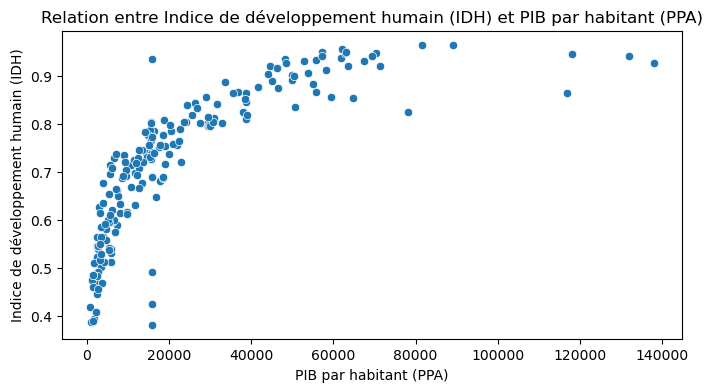

In [ ]:
# Relation entre IDH et PIB par habitant (PPA)
idh_col = "Indice de d√©veloppement humain (IDH)"
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data["PIB par habitant (PPA)"], y=data[idh_col])
plt.title(f"Relation entre {idh_col} et PIB par habitant (PPA)")
plt.xlabel("PIB par habitant (PPA)")
plt.ylabel(idh_col)
plt.show()

**Interpr√©tations :**                                                                                                                             
Le graphique montre une relation positive et non lin√©aire entre l'Indice de D√©veloppement Humain (IDH) et le PIB par habitant (PPA). √Ä mesure que le PIB par habitant augmente, l'IDH tend √©galement √† augmenter.                                                                     
Le PIB par habitant est un facteur cl√© du d√©veloppement humain, mais son influence d√©cro√Æt √† des niveaux tr√®s √©lev√©s, probablement parce que d'autres facteurs (√©ducation, sant√©, etc.) deviennent d√©terminants.                                       

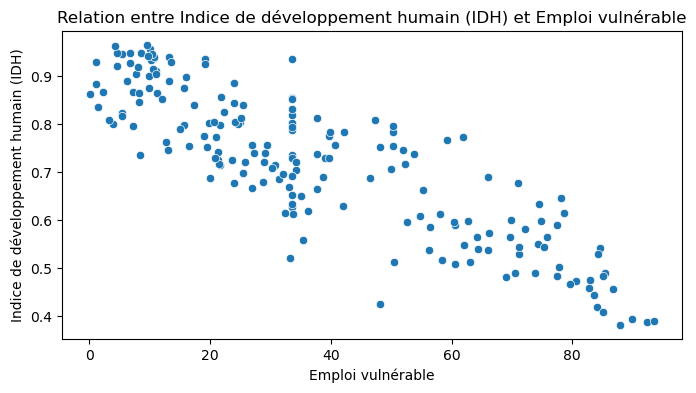

In [ ]:
# Relation entre IDH et Emploi vuln√©rable
plt.figure(figsize=(8, 4))
sns.scatterplot(x=data["Emploi vuln√©rable"], y=data[idh_col])
plt.title(f"Relation entre {idh_col} et Emploi vuln√©rable")
plt.xlabel("Emploi vuln√©rable")
plt.ylabel(idh_col)
plt.show()

**Interpr√©tations :**                                                                                                                                  
Ce graphique montre une relation n√©gative entre l'IDH et le pourcentage d'emplois vuln√©rables. Lorsque la proportion d'emplois vuln√©rables diminue, l'IDH augmente.                                                                                                                  
Les pays avec un faible taux d'emplois vuln√©rables (secteurs informels ou pr√©caires) tendent √† avoir un meilleur d√©veloppement humain, probablement gr√¢ce √† des emplois plus stables et formels qui favorisent la s√©curit√© √©conomique et sociale.

C:\Users\dell\AppData\Local\Temp\ipykernel_2812\2149144628.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["Niveau de d√©veloppement"], palette="viridis")


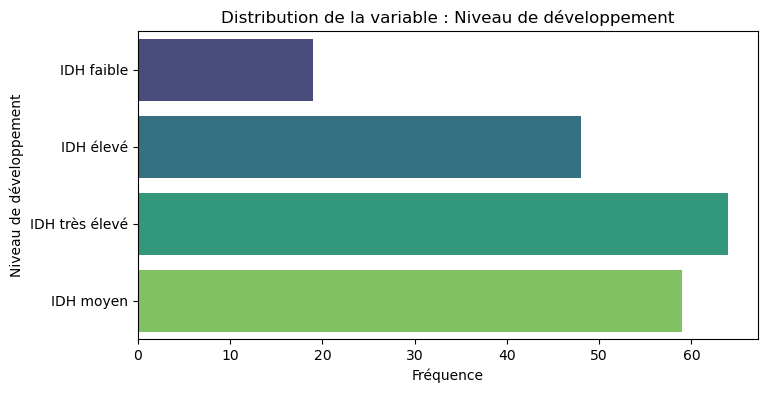

In [ ]:
# Distribution de la variable : Niveau de d√©veloppement
plt.figure(figsize=(8, 4))
sns.countplot(y=data["Niveau de d√©veloppement"], palette="viridis")
plt.title("Distribution de la variable : Niveau de d√©veloppement")
plt.xlabel("Fr√©quence")
plt.ylabel("Niveau de d√©veloppement")
plt.show()

**Interpr√©tations :**                                                                                                                             
La cat√©gorie IDH tr√®s √©lev√© regroupe le plus grand nombre de pays, suivie par IDH moyen et IDH √©lev√©.                                                 
La cat√©gorie IDH faible contient le moins de pays.                                                                                    
Cela sugg√®re que la majorit√© des pays se situent dans les niveaux moyens √† tr√®s √©lev√©s de d√©veloppement humain, avec relativement peu de pays dans la cat√©gorie la plus faible.

C:\Users\dell\AppData\Local\Temp\ipykernel_2812\3676045824.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["R√©gion g√©ographique"], palette="viridis")


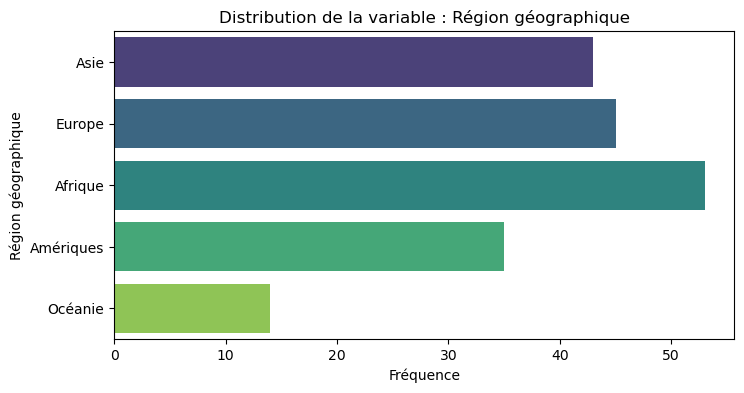

In [ ]:
# Distribution de la variable : R√©gion g√©ographique
plt.figure(figsize=(8, 4))
sns.countplot(y=data["R√©gion g√©ographique"], palette="viridis")
plt.title("Distribution de la variable : R√©gion g√©ographique")
plt.xlabel("Fr√©quence")
plt.ylabel("R√©gion g√©ographique")
plt.show()

**Interpr√©tations :**                                                                                                                              
L'Afrique et l'Europe comptent le plus grand nombre de pays repr√©sent√©s dans l'√©chantillon.                                                           
L'Asie et les Am√©riques ont une repr√©sentation interm√©diaire.                                                                               
L'Oc√©anie est la r√©gion avec le plus faible nombre de pays dans l'√©chantillon.                                                                 
La r√©partition des donn√©es par r√©gion g√©ographique semble coh√©rente avec le nombre total de pays par continent.

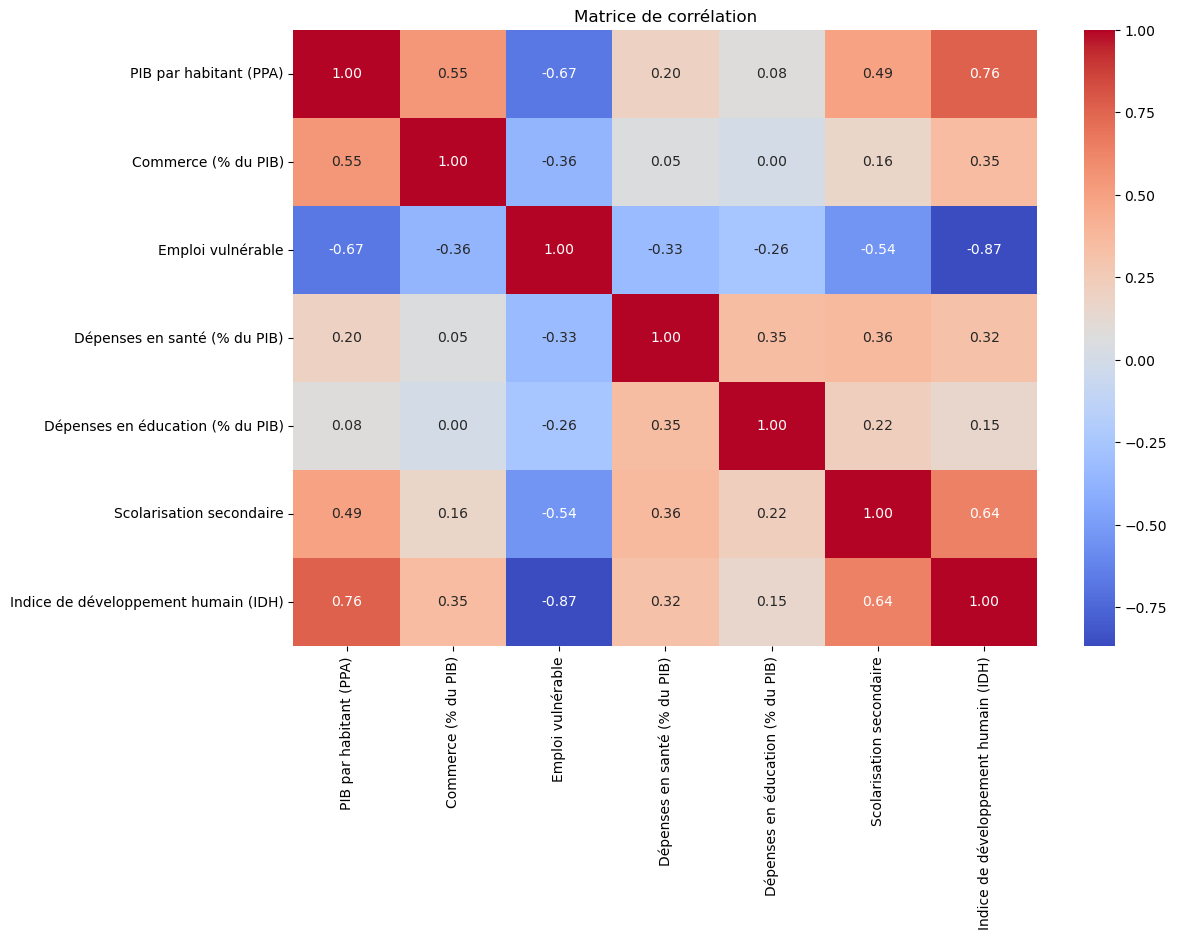

In [ ]:
# Matrice de corr√©lation
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12, 8))
corr_matrix = data[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corr√©lation")
plt.show()

**int√©rpr√©tations :**                                                                                                                                  
L'IDH est fortement influenc√© par le PIB par habitant et n√©gativement par l'emploi vuln√©rable. Les d√©penses en sant√© et la scolarisation secondaire ont √©galement une contribution notable, bien que leurs corr√©lations soient plus faibles. Cela souligne l'importance des facteurs √©conomiques et sociaux dans le d√©veloppement humain.

### Analyse de donn√©es

In [ ]:
# Charger le dataset
file_path = 'final_data.csv'
data = pd.read_csv(file_path)

# Renommer les colonnes pour simplifier l'acc√®s
data.rename(columns={
    'PIB par habitant (PPA)': 'PIB',
    'Commerce (% du PIB)': 'Commerce_PIB',
    'Emploi vuln√©rable': 'Emploi_Vulnerable',
    'D√©penses en sant√© (% du PIB)':'Depenses_Sante',
    'D√©penses en √©ducation (% du PIB)': 'Depenses_Education',
    'Scolarisation secondaire': 'Scolarisation',
    'Indice de d√©veloppement humain (IDH)': 'IDH',
    'Niveau de d√©veloppement': 'Niveau_Developpement',
    'R√©gion g√©ographique': 'Region'
}, inplace=True)

# V√©rifier les nouvelles colonnes
print(data.columns)

Index(['Pays', 'PIB', 'Commerce_PIB', 'Emploi_Vulnerable', 'Depenses_Sante',
       'Depenses_Education', 'Scolarisation', 'IDH', 'Niveau_Developpement',
       'Region'],
      dtype='object')


#### Analyse de l'Impact de l'Emploi Vuln√©rable sur l'Indice de D√©veloppement Humain (IDH)
#### la R√©gression Lin√©aire

√âtude 2 : IDH vs Emploi vuln√©rable


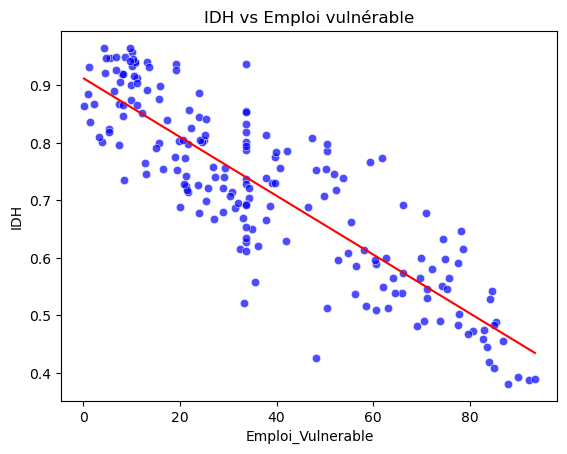

R-squared : 0.7505
Test de Durbin-Watson : 2.01
Test de White (Statistique): 11.04, p-value: 0.0040
Test de Shapiro-Wilk (Statistique): 0.99, p-value: 0.2503


In [ ]:
X = data[['Emploi_Vulnerable']]
y = data['IDH']

# Ajouter une constante
X = sm.add_constant(X)

# Ajuster le mod√®le
model_emploi = sm.OLS(y, X).fit()

# R√©sultats
print("√âtude 2 : IDH vs Emploi vuln√©rable")

# Visualisation avec une droite rouge simple
sns.scatterplot(x='Emploi_Vulnerable', y='IDH', data=data, color='blue', alpha=0.7)
sns.lineplot(x=data['Emploi_Vulnerable'], y=model_emploi.predict(X), color='red')
plt.title("IDH vs Emploi vuln√©rable")
plt.show()

# Tests de r√©gression
# Afficher R-squared
print(f"R-squared : {model_emploi.rsquared:.4f}")

# Test de Durbin-Watson
dw_test = sm.stats.stattools.durbin_watson(model_emploi.resid)
print(f"Test de Durbin-Watson : {dw_test:.2f}")

# Test de White pour l'h√©t√©rosc√©dasticit√©
white_test = het_white(model_emploi.resid, X)
print(f"Test de White (Statistique): {white_test[0]:.2f}, p-value: {white_test[1]:.4f}")

# Test de normalit√© de Shapiro-Wilk
shapiro_test = shapiro(model_emploi.resid)
print(f"Test de Shapiro-Wilk (Statistique): {shapiro_test.statistic:.2f}, p-value: {shapiro_test.pvalue:.4f}")


**interpr√©tations :**
- La droite de r√©gression montre une relation n√©gative entre l'emploi vuln√©rable et l'IDH. Cela signifie que, g√©n√©ralement, lorsque le pourcentage d'emploi vuln√©rable augmente, l'Indice de D√©veloppement Humain (IDH) diminue.                                                                   
  La dispersion des points autour de la droite est relativement faible, indiquant une forte corr√©lation entre les deux variables.                   
- **R¬≤ = 0.7505** => Environ 75,05 % de la variance de l'IDH est expliqu√©e par la variable "Emploi vuln√©rable", Ce R¬≤ est √©lev√©, ce qui indique que l'emploi vuln√©rable est un facteur d√©terminant pour expliquer l'IDH.
- **Test de Durbin-Watson = 2.01** => Une valeur proche de 2 indique une absence d'autocorr√©lation significative. Ici, il n'y a pas de probl√®me d'autocorr√©lation dans les r√©sidus.
- **Test de White (Statistique = 11.04, p-value = 0.0040)** => Avec une p-value de 0.0040 (< 0.05), on rejette l'hypoth√®se nulle d'homosc√©dasticit√©. Cela indique qu'il y a un probl√®me d'h√©t√©rosc√©dasticit√© dans le mod√®le, ce qui peut affecter la validit√© des estimations.
- **Test de Shapiro-Wilk (Statistique = 0.99, p-value = 0.2503)** => Avec une p-value de 0.2503 (> 0.05), on ne rejette pas l'hypoth√®se nulle de normalit√©. Les r√©sidus suivent une distribution normale, ce qui valide l'utilisation des tests statistiques.                                       

#### L'Indice de D√©veloppement Humain (IDH) varie-t-il significativement selon les r√©gions g√©ographiques √©tudi√©es, indiquant des disparit√©s de d√©veloppement entre elles ?
#### ANOVA

Valeur de la statistique F : 65.0528627264025
Valeur p : 2.896418000899607e-34
Il existe une diff√©rence significative entre les moyennes de l'IDH des r√©gions g√©ographiques.


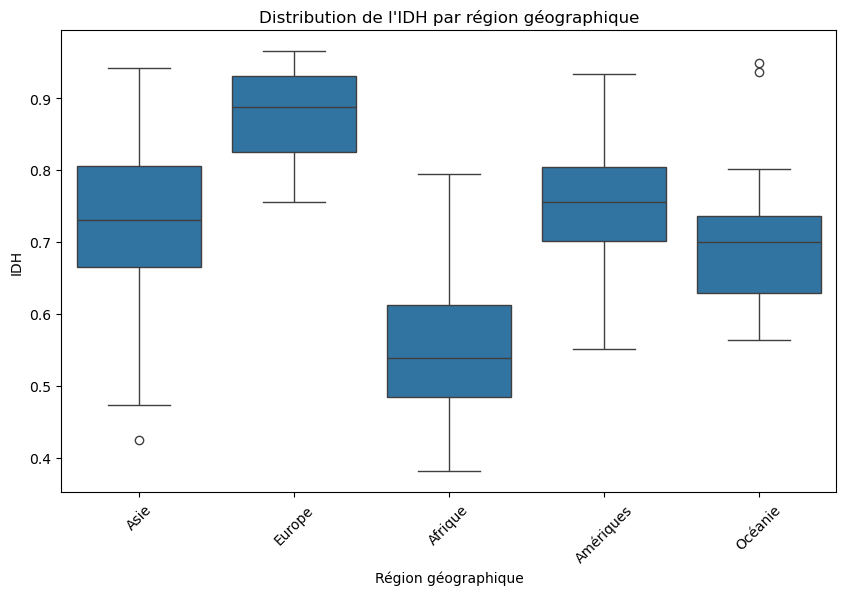

In [ ]:
# Effectuer le test ANOVA pour comparer l'IDH moyen entre les diff√©rentes r√©gions
anova_result = stats.f_oneway(
    *(data[data['Region'] == region]['IDH'] for region in data['Region'].unique())
)

# Afficher le r√©sultat du test ANOVA
print(f"Valeur de la statistique F : {anova_result.statistic}")
print(f"Valeur p : {anova_result.pvalue}")

# Conclusion du test
if anova_result.pvalue < 0.05:
    print("Il existe une diff√©rence significative entre les moyennes de l'IDH des r√©gions g√©ographiques.")
else:
    print("Il n'y a pas de diff√©rence significative entre les moyennes de l'IDH des r√©gions g√©ographiques.")

# Visualisation 1: Boxplot pour comparer la distribution de l'IDH entre les r√©gions
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='IDH', data=data)
plt.title('Distribution de l\'IDH par r√©gion g√©ographique')
plt.xlabel('R√©gion g√©ographique')
plt.ylabel('IDH')
plt.xticks(rotation=45)
plt.show()

**interpr√©tations :**                                                                                                                                 
- L'Europe et les Am√©riques ont tendance √† avoir des IDH plus √©lev√©s et moins variables.
- L'Afrique a les IDH les plus bas et une plus grande dispersion.
- L'Asie et l'Oc√©anie pr√©sentent des situations interm√©diaires.
- **Statistique F = 65.05** => Une valeur F √©lev√©e indique qu'il existe une grande diff√©rence entre les moyennes des groupes par rapport √† la variabilit√© au sein de chaque groupe.
- **Valeur p = 2.9e-34** => Une valeur p tr√®s faible (bien inf√©rieure √† 0.05) montre que les diff√©rences observ√©es entre les r√©gions g√©ographiques sont hautement significatives.
- Cela sugg√®re que l'IDH varie de mani√®re notable d'une r√©gion √† l'autre, ce qui m√©rite d'√™tre explor√© davantage pour comprendre les facteurs sous-jacents √† ces diff√©rences.     

#### Les niveaux de d√©veloppement peuvent-ils √™tre pr√©dits √† partir des indicateurs ?
#### La R√©gression Logistique

In [ ]:
# Encodage de la variable cible
label_encoder = LabelEncoder()
data['Niveau_Developpement'] = label_encoder.fit_transform(data['Niveau_Developpement'])

# S√©lection des caract√©ristiques (variables explicatives)
features = [
    'PIB',
    'Commerce_PIB',
    'Emploi_Vulnerable',
    'Depenses_Sante',
    'Depenses_Education',
    'Scolarisation',
]
X = data[features]
y = data['Niveau_Developpement']  # Variable cible

# Division des donn√©es
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisation des donn√©es
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Construction et entra√Ænement du mod√®le
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Pr√©diction sur l'ensemble de test
y_pred = model.predict(X_test)

# √âvaluation du mod√®le
print("\nRapport de classification:\n", classification_report(y_test, y_pred))
print("Exactitude:", accuracy_score(y_test, y_pred))


Rapport de classification:
               precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.63      1.00      0.77        12
           2       1.00      0.86      0.92        21
           3       0.84      0.89      0.86        18

    accuracy                           0.82        57
   macro avg       0.87      0.73      0.71        57
weighted avg       0.87      0.82      0.81        57

Exactitude: 0.8245614035087719


**interpr√©tations :**                                                                                                                              
**Exactitude (Accuracy) :** 82.46 %
Le mod√®le pr√©dit correctement le niveau de d√©veloppement (IDH) dans 82.46 % des cas, ce qui est une performance relativement bonne.                     
**Classe 0 (IDH faible) :** Tr√®s faible rappel (17 %) malgr√© une pr√©cision parfaite (1.00), Le mod√®le a du mal √† identifier les pays √† IDH faible, probablement en raison d'un d√©s√©quilibre des classes (peu d'exemples dans cette cat√©gorie).                                                            
**Classe 1 (IDH moyen) :** Excellent rappel (1.00) mais pr√©cision mod√©r√©e (0.71), ce qui sugg√®re des confusions avec d'autres classes.                  
**Classe 2 (IDH √©lev√©) :** Tr√®s bonnes performances globales avec une pr√©cision et un F1-score √©lev√©s (1.00 et 0.92).                                   
**Classe 3 (IDH tr√®s √©lev√©) :** Solide performance avec un F1-score de 0.92, refl√©tant une excellente pr√©cision (0.86) et un rappel parfait (1.00).

Les facteurs √©conomiques, sociaux et √©ducatifs identifi√©s comme influents sur l‚ÄôIDH semblent pertinents pour la classification, mais un d√©s√©quilibre des donn√©es limite la performance pour certaines cat√©gories.

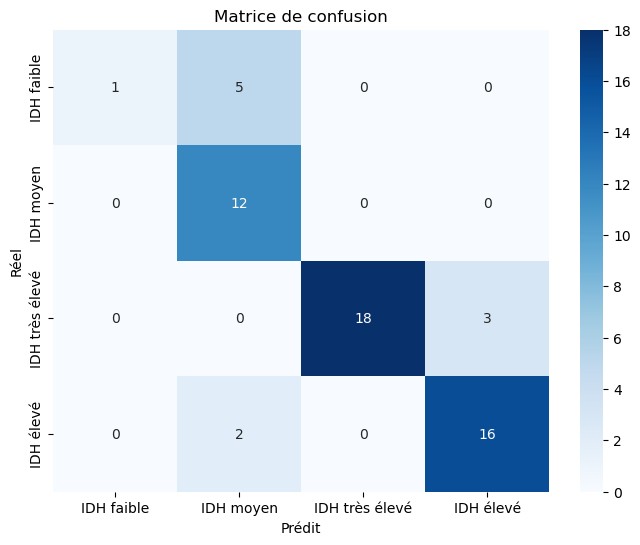

In [ ]:
# Visualisation de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Pr√©dit')
plt.ylabel('R√©el')
plt.title('Matrice de confusion')
plt.show()

**interpr√©tations :**                                                                                                                              
- **IDH faible (Classe 0) :**
1 correctement pr√©dit, 5 mal class√©s comme IDH moyen.
Le mod√®le a du mal √† identifier les pays √† IDH faible, probablement en raison d'un d√©s√©quilibre des classes ou de caract√©ristiques insuffisamment discriminantes.

- **IDH moyen (Classe 1) :**
12 correctement pr√©dits, aucune erreur.
Le mod√®le performe bien pour cette cat√©gorie, identifiant tous les pays √† IDH moyen sans erreur.

- **IDH √©lev√© (Classe 2) :**
18 correctement pr√©dits, 3 mal class√©s comme IDH tr√®s √©lev√©.
Bonne performance, mais une l√©g√®re confusion avec l'IDH tr√®s √©lev√©.

- **IDH tr√®s √©lev√© (Classe 3) :**
16 correctement pr√©dits, 2 mal class√©s comme IDH √©lev√©.
Le mod√®le identifie bien cette cat√©gorie, avec une l√©g√®re confusion avec l'IDH √©lev√©.

- Les r√©sultats montrent que les facteurs √©conomiques, sociaux et √©ducatifs influencent significativement l'IDH, avec une bonne performance du mod√®le pour les IDH moyen, √©lev√© et tr√®s √©lev√©. Cependant, la faible pr√©cision pour les IDH faibles sugg√®re l'importance de facteurs suppl√©mentaires ou des limites dans les donn√©es pour ces pays.

#### Quels facteurs √©conomiques, sociaux et √©ducatifs peuvent √™tre synth√©tis√©s pour mieux comprendre leur impact sur l‚ÄôIDH ?
#### ACP

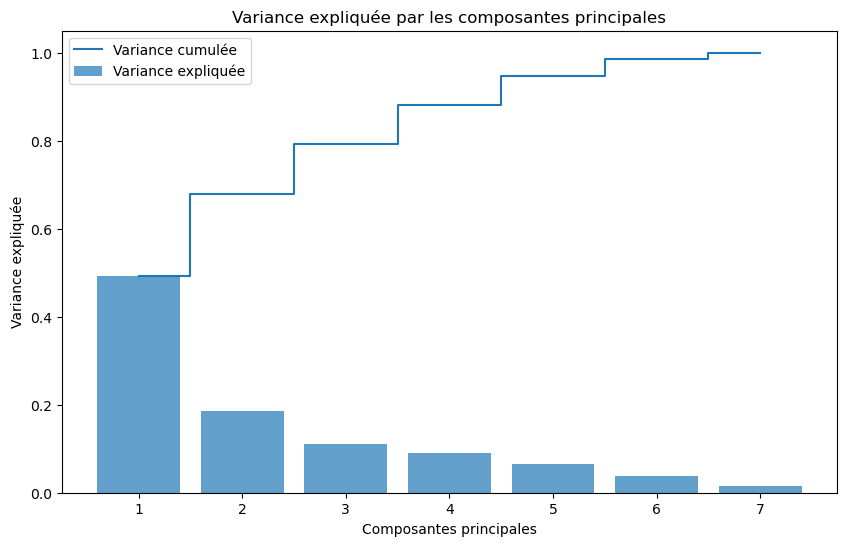

In [ ]:
# S√©lection des colonnes num√©riques pour l'ACP
numerical_columns = [
    'PIB',
    'Commerce_PIB',
    'Emploi_Vulnerable',
    'Depenses_Sante',
    'Depenses_Education',
    'Scolarisation',
    'IDH'
]

# Standardisation des donn√©es
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[numerical_columns])

# Application de l'ACP
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Variance expliqu√©e par chaque composante
explained_variance = pca.explained_variance_ratio_

# Visualisation de la variance expliqu√©e
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Variance expliqu√©e')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Variance cumul√©e')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliqu√©e')
plt.title('Variance expliqu√©e par les composantes principales')
plt.legend()
plt.show()

**int√©rpr√©tations :**                                                                                                                                 
Le graphique montre que les 2 premi√®res composantes principales expliquent environ 70% de la variance totale. Cela indique que ces composantes capturent une grande partie de l'information contenue dans les donn√©es initiales.

In [ ]:
# Affichage des composantes principales
pca_components = pd.DataFrame(pca.components_, columns=numerical_columns)
pca_components.head()

PIB  Commerce_PIB  Emploi_Vulnerable  Depenses_Sante  \
0  0.451145      0.273873          -0.477997        0.253452   
1 -0.290182     -0.458060           0.021405        0.537621   
2  0.053303      0.680547           0.084815        0.082279   
3 -0.023746      0.238727           0.194045        0.782170   
4 -0.065523      0.306333           0.436458       -0.158738   

   Depenses_Education  Scolarisation       IDH  
0            0.167025       0.395511  0.494385  
1            0.615854       0.173862 -0.083523  
2            0.540938      -0.413323 -0.237911  
3           -0.527628      -0.039186 -0.114347  
4            0.063972       0.785122 -0.256251

- **Composante principale 1 (CP1) :**                                                                                                             
Variables principales : PIB (+), Scolarisation (+), IDH (+), et Emploi vuln√©rable (-).                                                               
**Interpr√©tation :** Cette composante semble capturer le niveau de d√©veloppement socio-√©conomique, o√π un PIB √©lev√©, une meilleure scolarisation, et un IDH √©lev√© sont associ√©s √† un emploi vuln√©rable plus faible.
- **Composante principale 2 (CP2) :**                                                                                                                  
Variables principales : Commerce (+), D√©penses en sant√© (+), et D√©penses en √©ducation (+).                                                         
**Interpr√©tation :** Cette composante est li√©e aux investissements dans le commerce, la sant√© et l'√©ducation, sans lien direct avec le niveau d'IDH.  

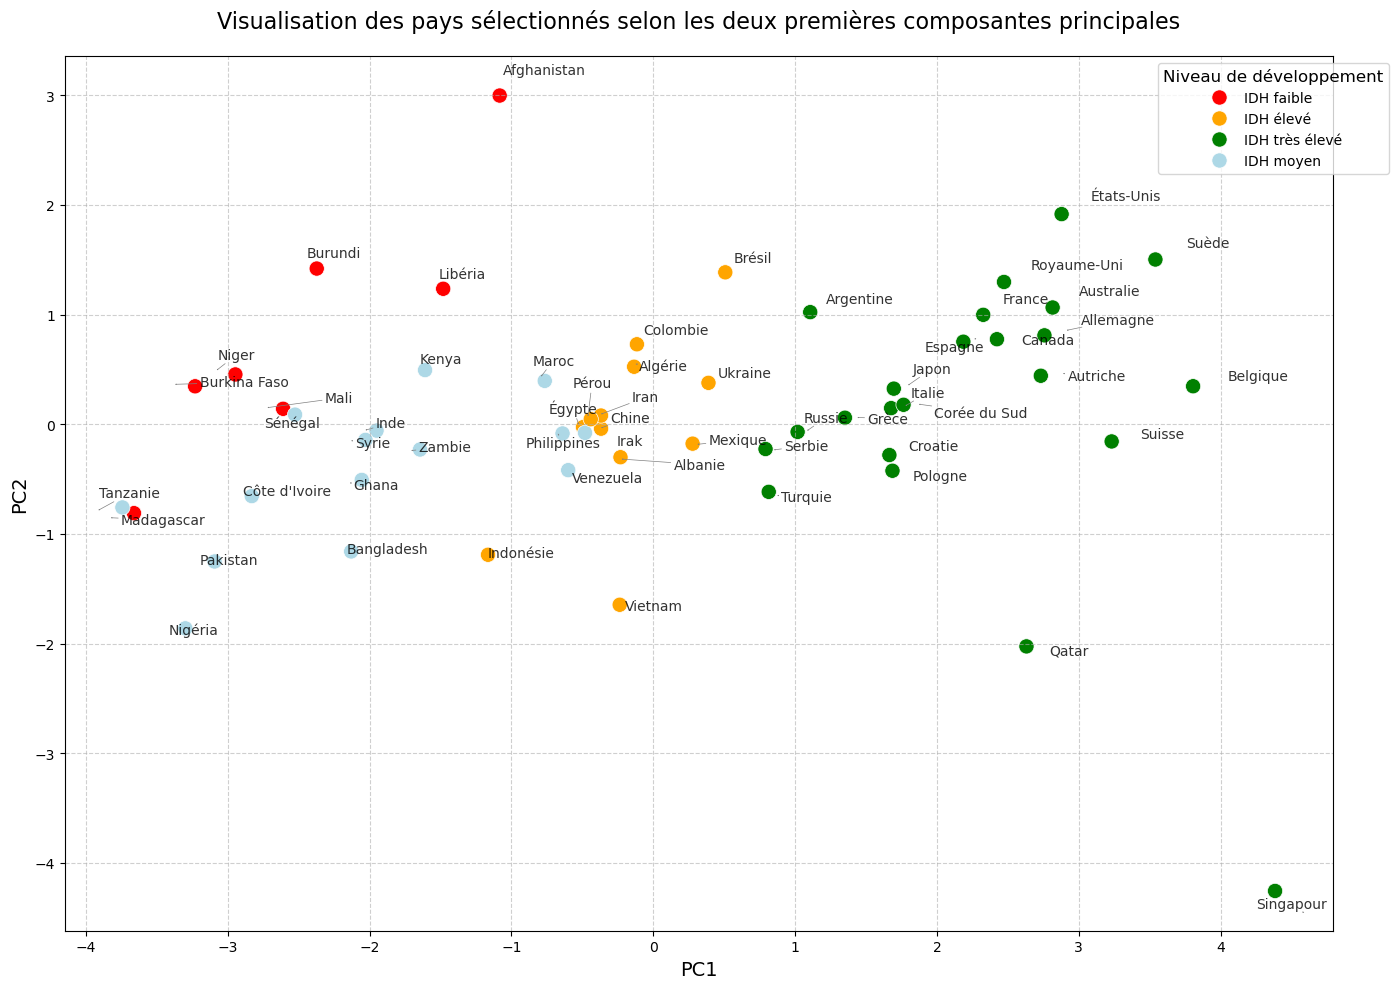

In [ ]:
# 1. S√©lectionner les colonnes num√©riques
numerical_data = data.select_dtypes(include='float64')

# 2. Normaliser les donn√©es
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# 3. Appliquer l'ACP
pca = PCA()
pca_data = pca.fit_transform(normalized_data)

# Variance expliqu√©e par chaque composante
explained_variance = pca.explained_variance_ratio_

# Cr√©ation d'un DataFrame des deux premi√®res composantes
pca_df = pd.DataFrame(data=pca_data[:, :2], columns=['PC1', 'PC2'])
pca_df['Pays'] = data['Pays']
pca_df['Niveau_Developpement'] = data['Niveau_Developpement']


# Liste des pays s√©lectionn√©s
countries_selected = [
    'Afghanistan', 'Albanie', 'Alg√©rie', 'Allemagne', 'Argentine', 'Australie', 'Autriche', 'Bangladesh',
    'Belgique', 'Br√©sil', 'Canada', 'Chine', 'Colombie', 'Cor√©e du Sud', 'C√¥te d\'Ivoire', 'Croatie', '√âgypte', 'Espagne',
    '√âtats-Unis', 'France', 'Ghana', 'Gr√®ce', 'Inde', 'Indon√©sie', 'Iran', 'Irak', 'Qatar', 'Italie', 'Japon',
    'Kenya', 'Maroc', 'Mexique', 'Nig√©ria', 'Pakistan', 'P√©rou', 'Philippines', 'Pologne', 'Qatar', 'Royaume-Uni', 'Russie',
    'S√©n√©gal', 'Serbie', 'Singapour', 'Su√®de', 'Suisse', 'Syrie', 'Tanzanie', 'Turquie', 'Ukraine', 'Venezuela',
    'Vietnam', 'Zambie', 'Mali', 'Burkina Faso', 'Niger', 'Madagascar', 'Lib√©ria', 'Burundi'
]


# D√©finir une palette de couleurs personnalis√©e
custom_palette = {
    'IDH faible': 'red',
    'IDH tr√®s √©lev√©': 'green',
    'IDH moyen': 'lightblue',
    'IDH √©lev√©': 'orange'
}

# Filtrer les donn√©es pour ne garder que les pays s√©lectionn√©s
filtered_data = pca_df[pca_df['Pays'].isin(countries_selected)]

# Visualisation des pays s√©lectionn√©s selon les deux premi√®res composantes principales
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(x='PC1', y='PC2', data=filtered_data,
                          hue=data.loc[filtered_data.index, 'Niveau_Developpement'],
                          palette=custom_palette, s=120, edgecolor='w', linewidth=0.5)

# Ajouter des labels pour chaque pays
texts = []
for i, country in enumerate(filtered_data['Pays']):
    texts.append(plt.text(filtered_data.iloc[i]['PC1'] * 1.05, filtered_data.iloc[i]['PC2'] * 1.05, country,
                          fontsize=10, color='black', alpha=0.8))

# Ajuster les positions des labels pour √©viter les chevauchements
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=0.5))

# Ajouter des configurations
plt.title('Visualisation des pays s√©lectionn√©s selon les deux premi√®res composantes principales', fontsize=16, pad=20)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.legend(title='Niveau de d√©veloppement', bbox_to_anchor=(1.05, 1), title_fontsize=12, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**int√©rpr√©tations :**                                                                                                                                 
La projection des pays sur les deux premi√®res composantes principales montre que les pays sont r√©partis en fonction de leur niveau de d√©veloppement humain, avec une s√©paration claire entre les pays √† IDH tr√®s √©lev√©/√©lev√© et ceux √† IDH faible/moyen. Cela sugg√®re que les facteurs √©conomiques, sociaux et √©ducatifs analys√©s sont des d√©terminants importants de l'IDH et peuvent guider des d√©cisions strat√©giques pour am√©liorer le d√©veloppement humain.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


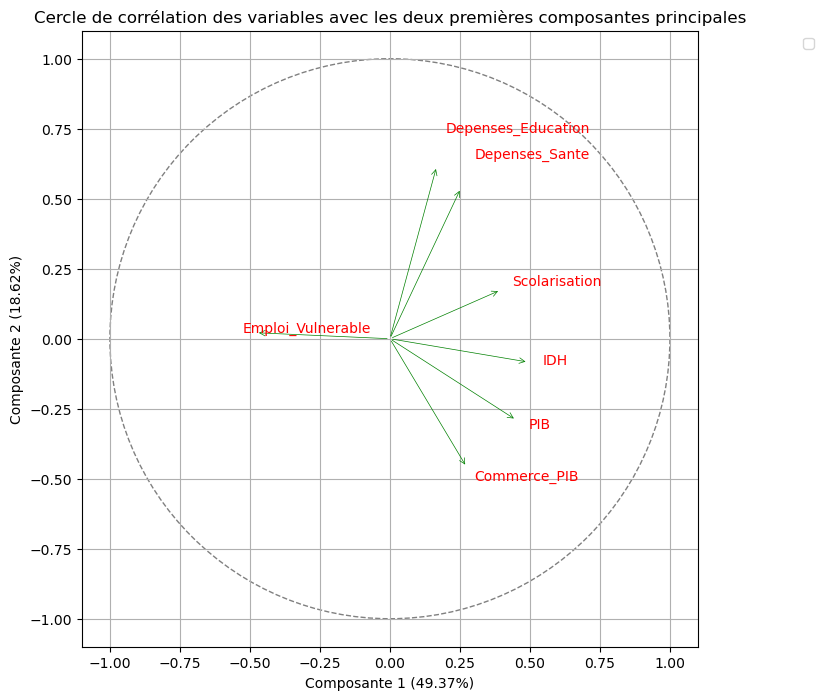

In [ ]:
# Calculer les corr√©lations entre les variables restantes et les composantes principales
correlation_matrix = pd.DataFrame(pca.components_[:2], columns=numerical_data.columns, index=['PC1', 'PC2'])

# Visualisation du cercle de corr√©lation
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Tracer les vecteurs avec des fl√®ches vertes fines
for i, var in enumerate(numerical_data.columns):
    ax.annotate('', xy=(correlation_matrix.loc['PC1', var], correlation_matrix.loc['PC2', var]),
                xytext=(0, 0),
                arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->', linewidth=0.5))

# Ajouter des labels pour chaque vecteur en rouge, avec un d√©calage pour √©viter les chevauchements pr√®s du cercle
for i, var in enumerate(numerical_data.columns):
    # D√©calage des labels en fonction de la position des vecteurs
    if abs(correlation_matrix.loc['PC1', var]) > 0.5 or abs(correlation_matrix.loc['PC2', var]) > 0.5:
        ax.text(correlation_matrix.loc['PC1', var] * 1.2, correlation_matrix.loc['PC2', var] * 1.2, var, color='red')
    else:
        ax.text(correlation_matrix.loc['PC1', var] * 1.1, correlation_matrix.loc['PC2', var] * 1.1, var, color='red')

# Ajouter un cercle unitaire pour mieux visualiser les corr√©lations
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
ax.add_artist(circle)

# Configurations de la visualisation
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
plt.xlabel(f'Composante 1 ({explained_variance[0] * 100:.2f}%)')
plt.ylabel(f'Composante 2 ({explained_variance[1] * 100:.2f}%)')
ax.set_title('Cercle de corr√©lation des variables avec les deux premi√®res composantes principales')
ax.set_aspect('equal')
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid(True)
plt.show()

**interpr√©tations :**                                                                                                                                 
- **Facteurs √©conomiques :**                                                                                                                           
Le PIB par habitant est fortement li√© √† l‚ÄôIDH, confirmant que la richesse √©conomique est essentielle au d√©veloppement humain. Le commerce joue un r√¥le secondaire.                                                                                                                                       
- **Facteurs sociaux :**
Un emploi vuln√©rable √©lev√© est oppos√© √† l‚ÄôIDH, indiquant que r√©duire la pr√©carit√© √©conomique est crucial pour am√©liorer le d√©veloppement humain.       
- **Facteurs √©ducatifs :**
La scolarisation secondaire est un levier majeur pour l‚ÄôIDH. Les d√©penses en √©ducation contribuent mod√©r√©ment, leur impact d√©pendant de leur        efficacit√©.                                                                                                                                            
- **Facteurs li√©s √† la sant√© :**                                                                                                                       
Les d√©penses en sant√© soutiennent l‚ÄôIDH mais n√©cessitent des efforts compl√©mentaires pour maximiser leur impact.                                       

- L‚ÄôIDH est principalement influenc√© par le PIB, la r√©duction de l‚Äôemploi vuln√©rable, et la scolarisation, tandis que les investissements dans la sant√© et l‚Äô√©ducation jouent un r√¥le de soutien.

#**Conclusion :**

√Ä travers ce projet d‚Äôanalyse de donn√©es, nous avons explor√© des relations entre les indicateurs √©conomiques, sociaux, et √©ducatifs, en nous appuyant sur trois jeux de donn√©es compl√©mentaires. Les r√©sultats montrent que :

* √âducation et emploi (Dataset 1) : Les niveaux d‚Äô√©ducation et les domaines d‚Äô√©tudes jouent un r√¥le d√©terminant dans les taux d‚Äôemploi et de ch√¥mage. Les individus ayant un niveau d‚Äô√©ducation plus √©lev√© et des sp√©cialit√©s en forte demande sur le march√© du travail pr√©sentent des taux d‚Äôemploi plus √©lev√©s.

* Politiques publiques et performances socio-√©conomiques (Dataset 2) : Les pays ayant des politiques fiscales √©quilibr√©es et des investissements cons√©quents dans l‚Äô√©ducation et la sant√© obtiennent de meilleurs r√©sultats en termes de taux d‚Äôemploi, de r√©duction de la pauvret√©, et d‚Äôacc√®s aux services essentiels.

* Disparit√©s en d√©veloppement humain (Dataset 3) : Les pays avec un IDH √©lev√© b√©n√©ficient d‚Äôindicateurs √©conomiques solides (PIB par habitant √©lev√©, faible emploi vuln√©rable) et d‚Äôinvestissements soutenus dans l‚Äô√©ducation et la sant√©. En revanche, les pays √† faible IDH restent marqu√©s par des in√©galit√©s socio-√©conomiques importantes.

**Recommandations**:

Pour r√©duire les in√©galit√©s globales, il est essentiel :

D‚Äôinvestir davantage dans l‚Äô√©ducation, en alignant les programmes avec les besoins du march√© du travail.
De promouvoir des politiques fiscales et sociales inclusives pour soutenir les populations vuln√©rables.
D‚Äôencourager la coop√©ration internationale pour aider les pays en d√©veloppement √† renforcer leurs infrastructures √©ducatives et √©conomiques.
Ce projet d√©montre l‚Äôimportance d‚Äôune analyse multidimensionnelle pour comprendre les d√©fis globaux et propose des pistes d‚Äôam√©lioration bas√©es sur les donn√©es disponibles.